# Rinaudo-Maltepe et. al. 2023: AnnData > Analysis


# Environment Setup (231116)

Install software from pip, apt, and Github.  Load modules, configure workspace settings.

In [ ]:
# CRITICAL STARTING ON 3/17/25 (RESTART REQUIRED)
!pip install -q numpy==1.26.4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# No editing of this code cell is required

# Environment Setup: verified working w/ Python 3.10.12 on 231004

# print python version to screen
!python --version

# pip install software
!pip install -q scanpy==1.9.4 leidenalg==0.8.10 harmonypy==0.0.9 scrublet==0.2.3
!pip install -q pydeseq2==0.4.12
!pip install -q adjustText==0.8 gdown==4.7.1

# import python packages
import os, sys, warnings
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import math

# install custom tools from github
!git clone https://github.com/WagnerLabUCSF/scToolsRNA-py
sys.path.append('scToolsRNA-py')
import scToolsRNA as dew

# set some ScanPy settings
sc.set_figure_params(dpi=120, figsize=[4,4], fontsize=7)
sc.settings.verbosity = 0

Python 3.11.13
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 57.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 63.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 1.6 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/u

Cloning into 'scToolsRNA-py'...
remote: Enumerating objects: 1229, done.
remote: Counting objects: 100% (386/386), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 1229 (delta 275), reused 323 (delta 213), pack-reused 843 (from 1)
Receiving objects: 100% (1229/1229), 191.55 KiB | 21.28 MiB/s, done.
Resolving deltas: 100% (889/889), done.


# Load preprocessed adata

In [ ]:
#source_path = '/content/drive/MyDrive/Colab Notebooks/Rinaudo-Maltepe-IVF/230801/'
#adata = sc.read_h5ad(source_path + 'RinaudoMaltepe2023_processed.h5ad')
#adata

# Update cluster annotations from CSV

In [ ]:
def get_gsheet_annots(adata, annotation_keys):
    annot_df = pd.read_csv('Oqani2025_Annotations.csv')

    # Loop through each annotation key
    for annotation_key in annotation_keys:
        annot_dict = dict(zip(annot_df['Leiden'], annot_df[annotation_key]))

        # Filter out NaN values from 'Annot' before applying the mapping
        valid_map = adata.obs['Annot'].dropna().astype(int)

        # Only map the non-NaN values
        adata.obs['Annot_' + annotation_key] = valid_map.map(annot_dict)

        # Restore NaN for any entries where ZMAP was NaN
        adata.obs['Annot_' + annotation_key].reindex(adata.obs.index, fill_value=pd.NA)

In [ ]:
adata.obs['Annot'] = adata.obs['leiden'].copy()
get_gsheet_annots(adata, ['celltype','subtype'])

In [ ]:
adata.obs['Annot_subtype_leiden'] = adata.obs['Annot_celltype'].astype(str) + '-' + adata.obs['leiden'].astype(str)
adata.obs['Annot_cellsubtype_leiden'] = adata.obs['Annot_celltype'].astype(str) + '-' + adata.obs['Annot_subtype'].astype(str) + '-' + adata.obs['leiden'].astype(str)

# ANALYSIS: All Cell Type Clusters

## UMAP overlay and dotplots of top-level annotations

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
adata_original = adata.copy()
adata = adata[adata.obs['Annot_subtype_leiden'] != 'nan-36'].copy()

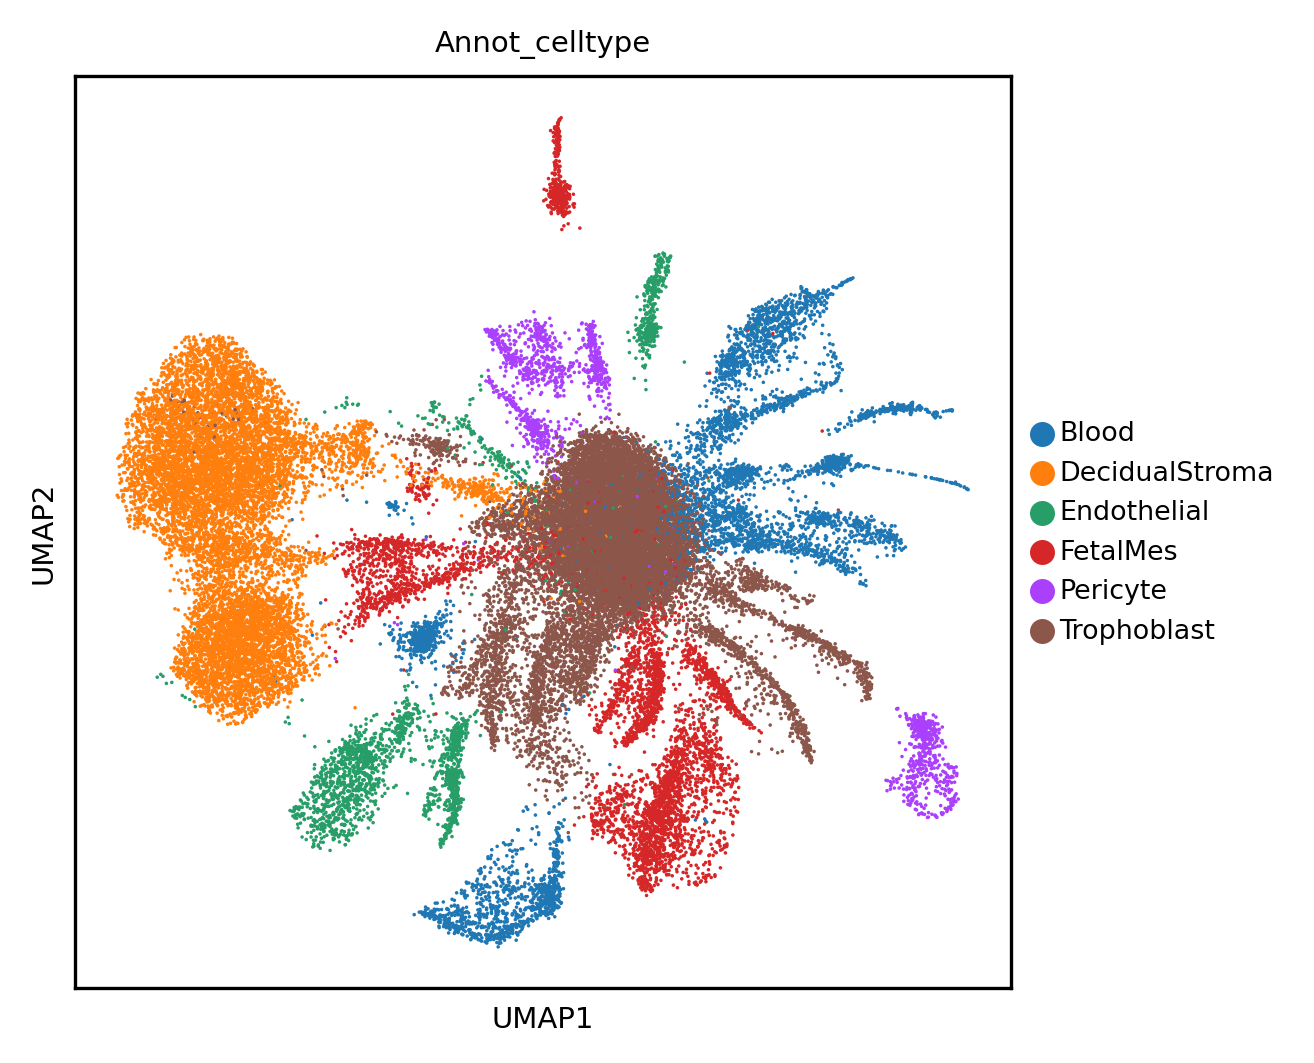

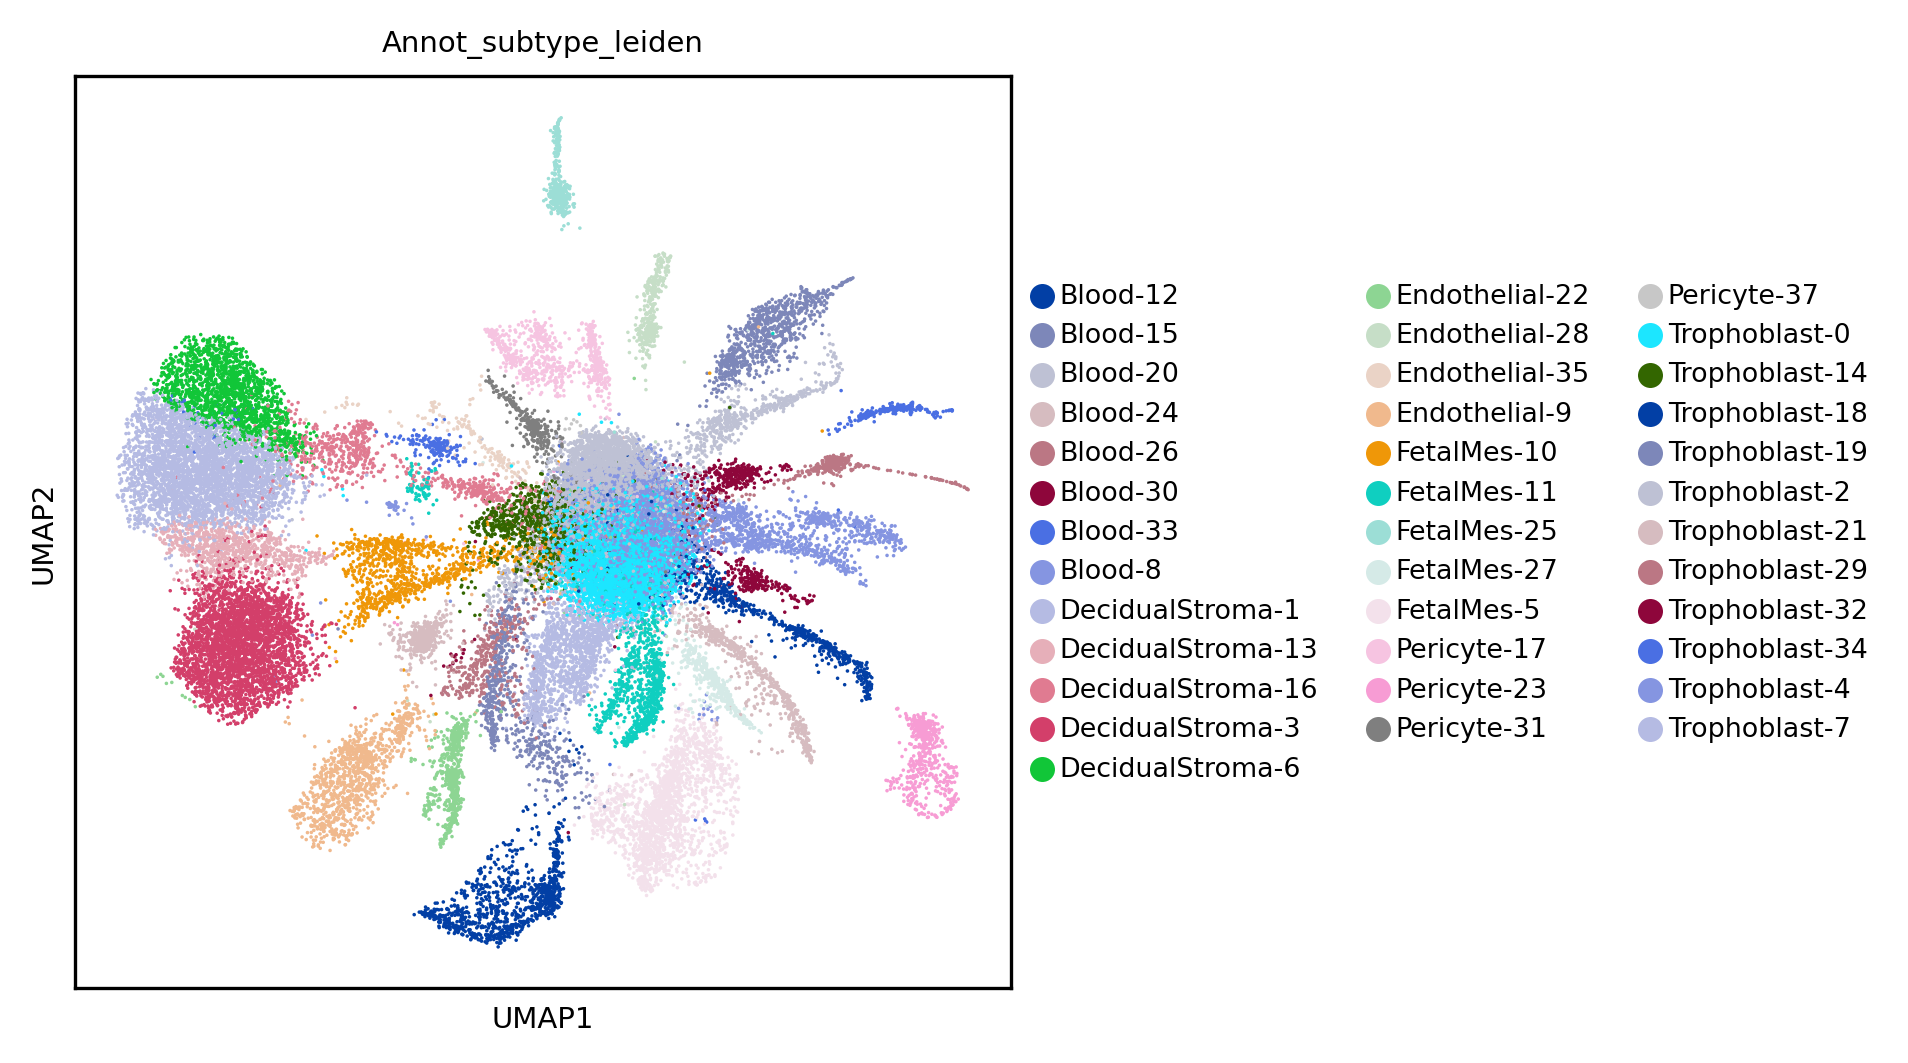

In [ ]:
# Generate UMAP overlays without NA cells plotted
adata.obs['Annot_subtype_leiden'] = adata.obs['Annot_subtype_leiden'].astype('str').astype('category')
sc.pl.umap(adata, color='Annot_celltype', palette=sc.pl.palettes.vega_10_scanpy)
sc.pl.umap(adata, color='Annot_subtype_leiden', palette=sc.pl.palettes.zeileis_28)

In [ ]:
# Generate UMAP overlays for sample conditions - multiple plotting options
sc.pl.umap(adata, color='condition', palette=sc.pl.palettes.default_20, sort_order=False)
sc.pl.umap(adata, color='library_id', palette=sc.pl.palettes.default_20)
sc.pl.umap(adata, color='library_id', palette=['#3182bd', '#6baed6', '#9ecae1', '#e6550d', '#fd8d3c', '#fdae6b'])

Output hidden; open in https://colab.research.google.com to view.

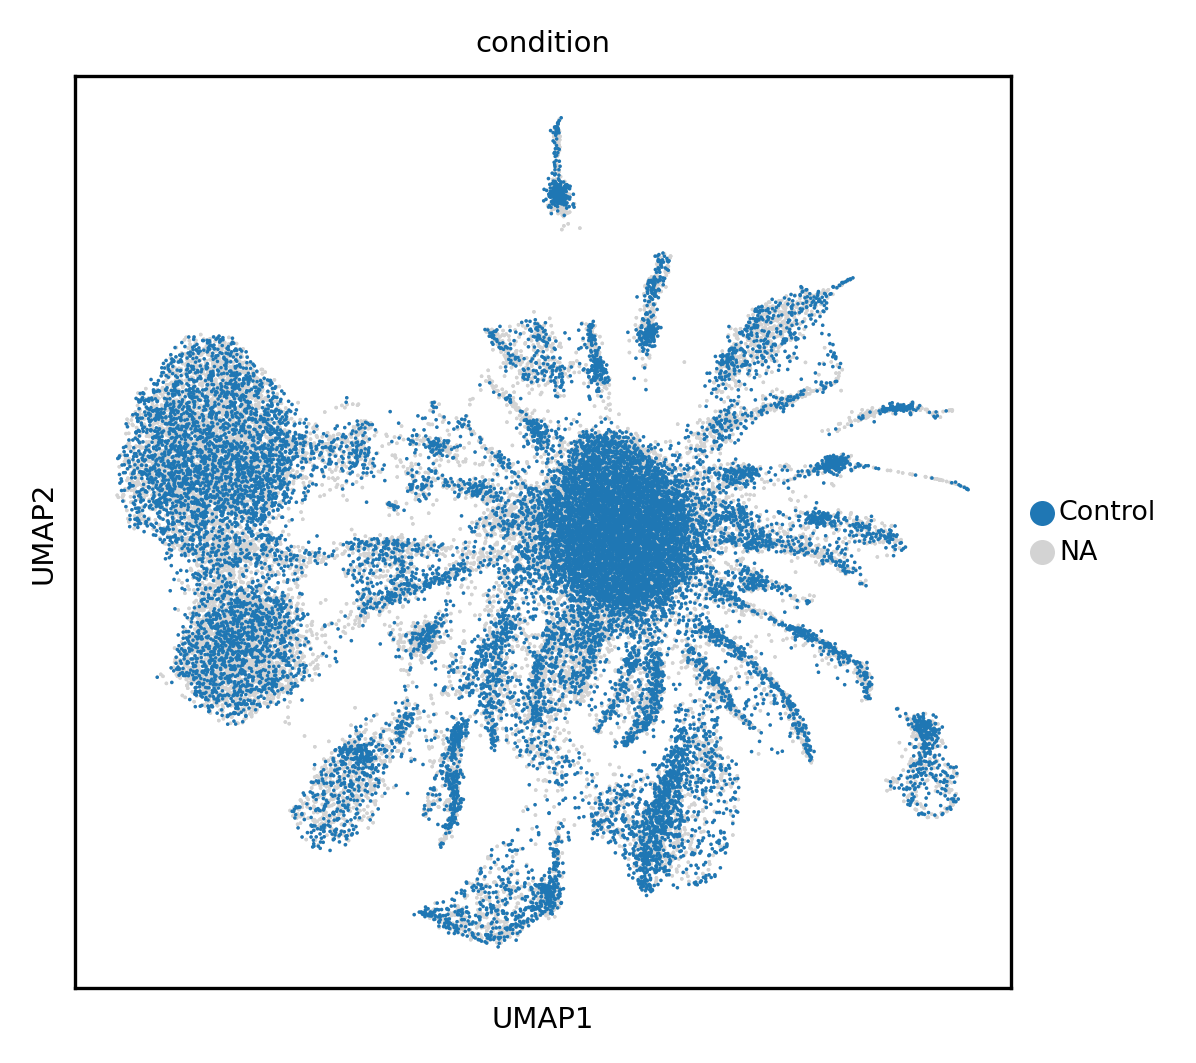

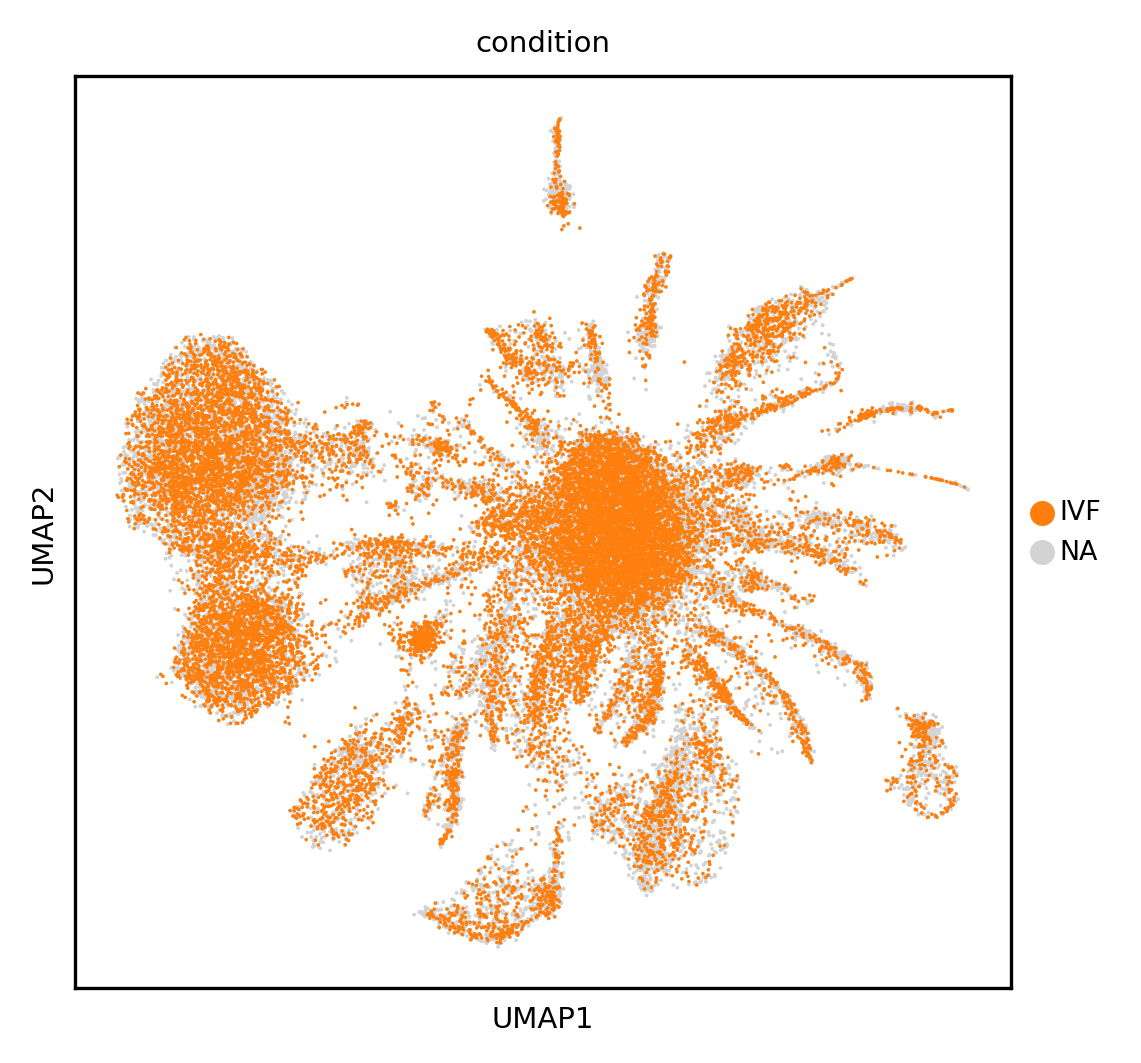

In [ ]:
# Plot each condition on top of the entire dataset in grey
ax = sc.pl.umap(adata, show=False)
sc.pl.umap(adata, color='condition', groups='Control', palette=sc.pl.palettes.default_20, ax=ax)

ax = sc.pl.umap(adata, show=False)
sc.pl.umap(adata, color='condition', groups='IVF', palette=sc.pl.palettes.default_20, ax=ax)

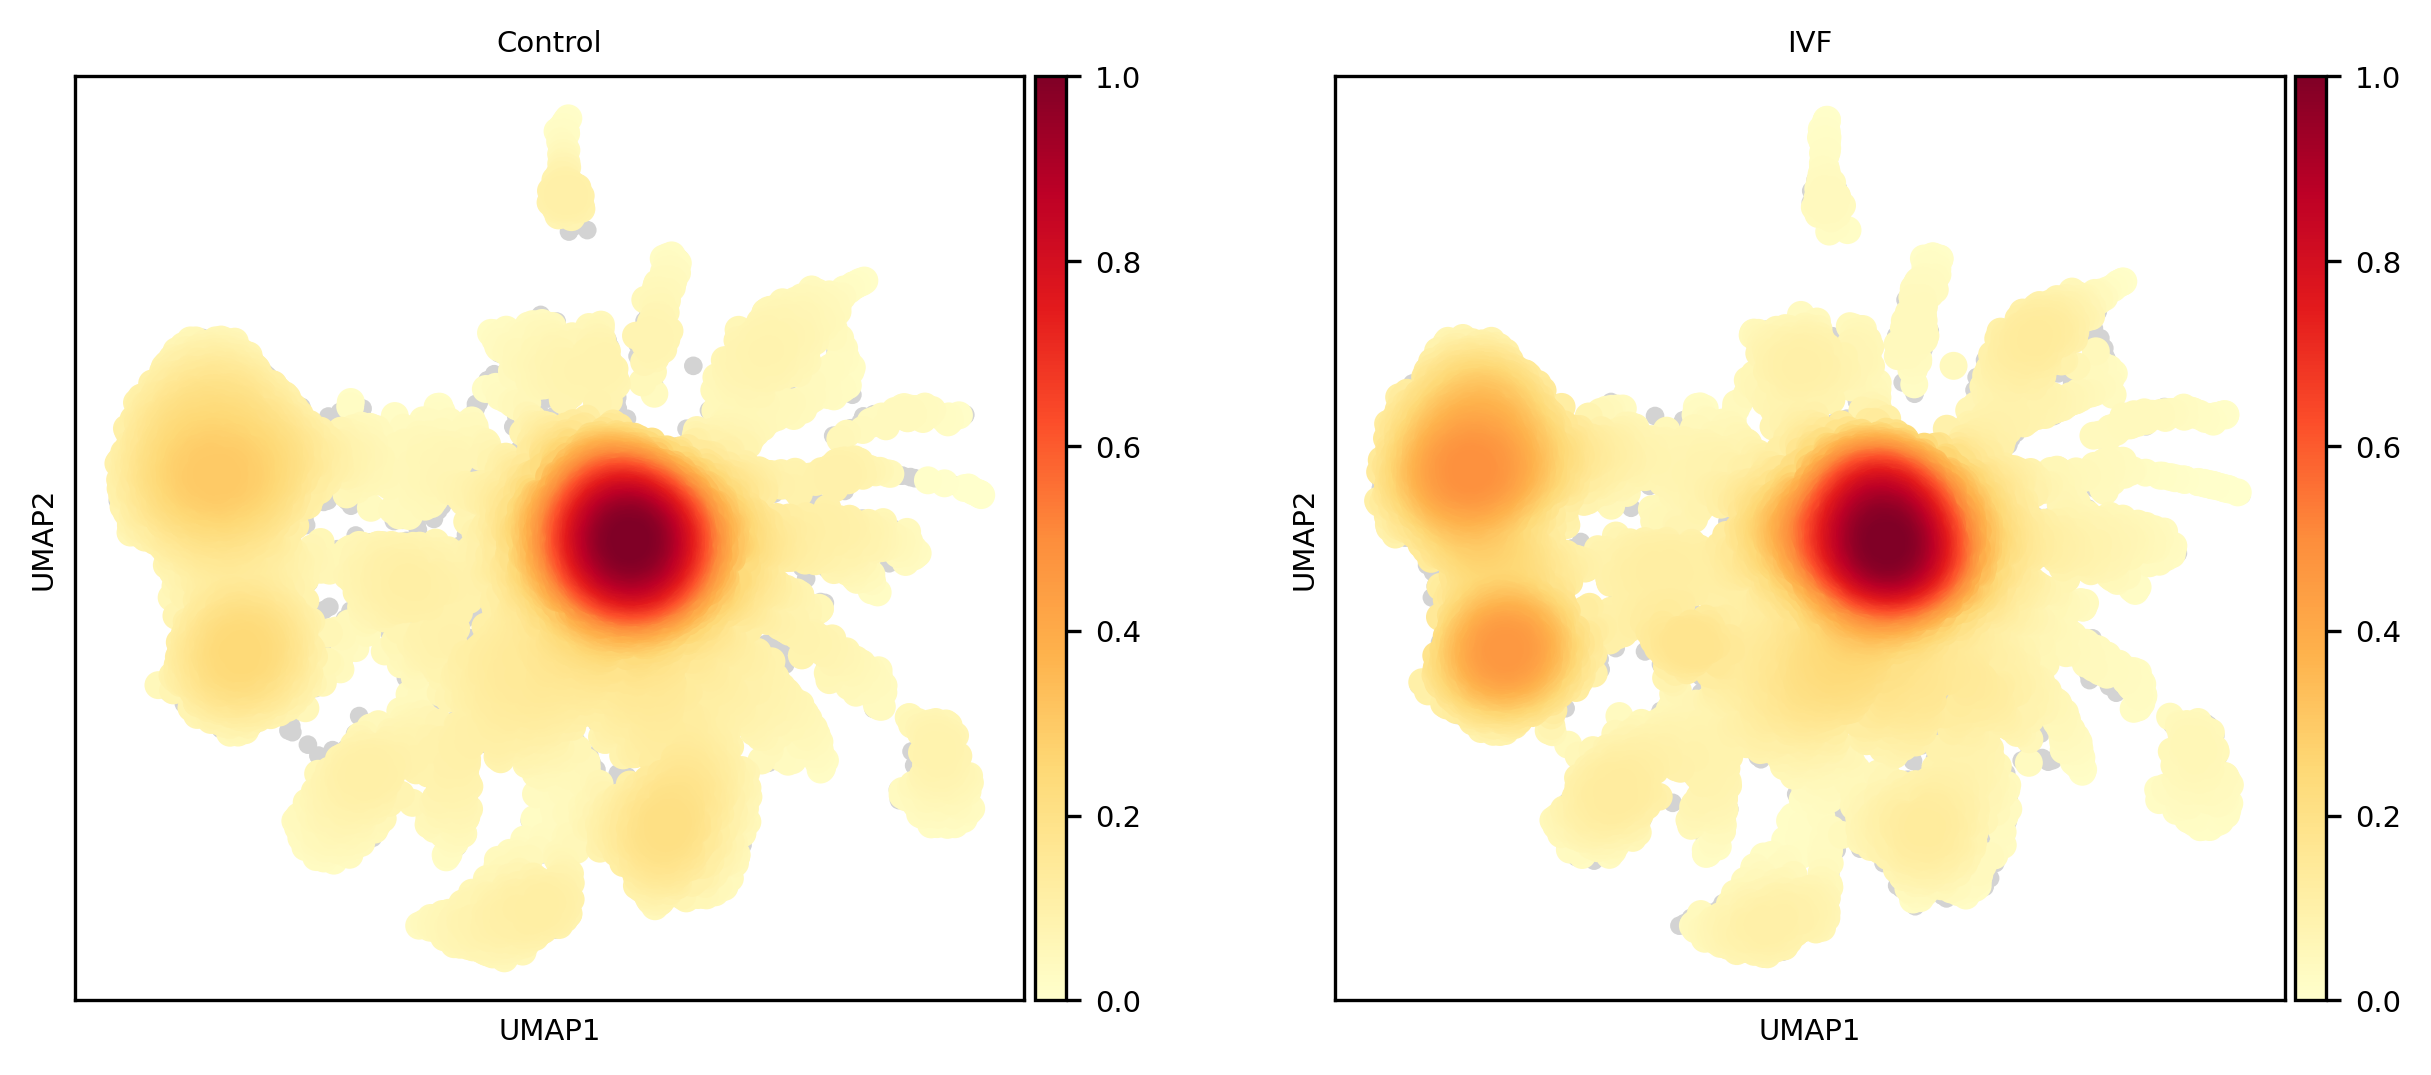

In [ ]:
# Embedding densities
sc.tl.embedding_density(adata, groupby='condition')
sc.pl.embedding_density(adata, groupby='condition')

## Rank Genes Groups Dotplot for Broad Cell Types (Annot_celltype)

In [ ]:
# Store the original rank_genes_groups result under a dedicated key
#adata.uns['rank_genes_groups_leiden_original'] = adata.uns['rank_genes_groups'].copy()

In [ ]:
sc.tl.rank_genes_groups(adata,
                        'Annot_celltype',
                        layer='raw',
                        log_transformed=True,
                        n_genes=100,
                        reference='rest',
                        method='wilcoxon',
                        corr_method='benjamini-hochberg')

In [ ]:
adata.uns['rank_genes_groups_celltype250129'] = adata.uns['rank_genes_groups'].copy()

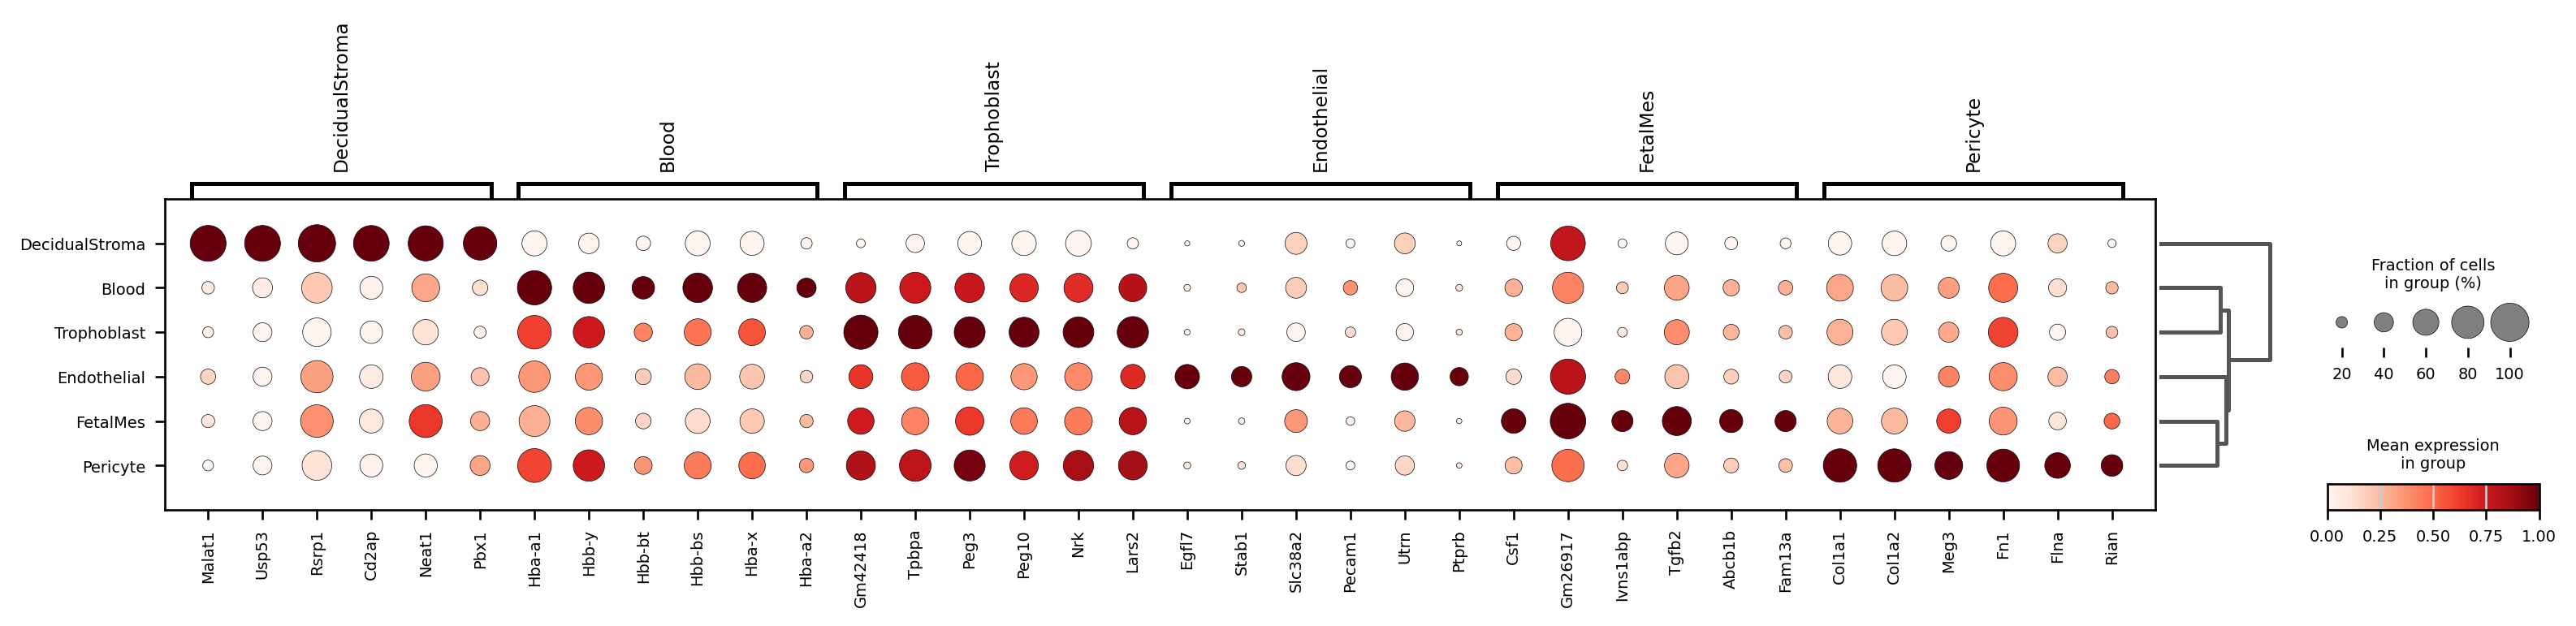

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata, key='rank_genes_groups_celltype250129', n_genes=6, standard_scale='var');

In [ ]:
dew.get_deg_table(adata)

Blood DecidualStroma Endothelial       FetalMes Pericyte    Trophoblast
0    Hba-a1         Malat1       Egfl7           Csf1   Col1a1  C430049B03Rik
1    Hbb-bt          Usp53       Stab1        Gm26917   Col1a2        Caskin1
2    Hbb-bs          Rsrp1     Slc38a2       Ivns1abp     Meg3               
3     Hba-x          Cd2ap      Pecam1          Tgfb2      Fn1               
4    Hba-a2          Neat1        Utrn         Abcb1b     Flna               
5    Slc4a1           Pbx1       Ptprb         Fam13a     Rian               
6     Ptprc           Xist       Arap3        Adamts9   Col3a1               
7      Irf8         Samhd1     Rapgef5             C3    Myh11               
8       Fyb        Tnfaip2    Arhgap31         Slc5a3    Acta2               
9     Epb41          Runx1      Rasip1             F3   Col5a1               
10    Adam8          Abcc5        Tcf4        Tmprss4   Plagl1               
11     Rgs1        Slco5a1      Adgrf5           Meg3    Tagln               
12    Runx3           Vmp1        Flt4          Celf2    Actg2               
13   Dock10            Hk2      Sema6d          Sgms2     Mylk               
14   Ptp4a3         Luc7l2       Mef2c          Bcat1     Dlk1               
15      Txk          Tacc1      Ushbp1  5330417C22Rik   Col6a3               
16  Lilrb4a        Gramd1b     Rasgrp3           Aqp8     Tpm2               
17    Alas2          Tshz2       Hdac9           Mgll     Tpm1               
18     Prf1           Tsix      Calcrl          Atg9b     Mirg               
19    Dock2           Ugcg        Fgd5         Slc1a5  Col11a1

## Perform pyDESeq2 DEG Tests: CellTypes vs Conditions

In [ ]:
# Create condition flags in adata.obs for organizing DEG test groups
condition_dict = {'FB1': 'Control',
                  'FB2': 'Control',
                  'FB3': 'Control',
                  'IVF1': 'IVF',
                  'IVF2': 'IVF',
                  'IVF3': 'IVF'}

adata.obs['condition'] = adata.obs['library_id']
adata.obs['condition'] = adata.obs['condition'].map(condition_dict).astype('category')
np.unique(adata.obs['condition'])

array(['Control', 'IVF'], dtype=object)

### Define pyDESEQ Functions

In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

def get_pydeseq2_sample_contrasts(adata, cluster_obs, sample_obs, condition_obs, condition_list, key_added='', csv_path=None):

    # Generate a pyDESeq2 results dataframe that reports cluster-level
    # pairwise comparisons (contrasts) between conditions over samples
    #
    # cluster_obs:      column in adata.obs containing per cell cluster assignments
    # sample_obs:       column in adata.obs containing per cell sample assignments (e.g. 'Control_1', 'Mutant_1', etc)
    # condition_obs:    column in adata.obs containing per cell condition assignments (e.g. 'Control', 'Mutant')
    # condition_list:   list specifying condition order for comparisons (e.g. ['Mutant', 'Control'])

    # Use a dictionary to store results
    pyDESeq_results = {}

    # Loop over all clusters
    clusters = list(np.unique(adata.obs[cluster_obs]))
    for cluster in clusters:
        print(cluster)
        adata_subset = adata[adata.obs[cluster_obs] == cluster]

        # Generate a set of pseudo-bulk profiles as adata objects - one for each sample (in each cluster)
        pb_adata_list = []
        for sample in np.unique(adata_subset.obs[sample_obs]):
            adata_subset_next = adata_subset[adata_subset.obs[sample_obs] == sample]
            del adata_subset_next.X
            adata_subset_next.X = adata_subset_next.layers['raw_nolog'] # make sure to use raw counts data
            pb_adata_next = sc.AnnData(X = np.array(adata_subset_next.X.sum(axis = 0)), var = adata_subset_next.var[[]])
            pb_adata_next.obs_names = [sample]
            pb_adata_next.obs[condition_obs] = adata_subset_next.obs[condition_obs].iloc[0]
            pb_adata_list.append(pb_adata_next)

        # Concatenate the sample-level pseudo-bulk adatas
        pb_adata = sc.concat(pb_adata_list)

        # Run pyDESeq2
        dds = DeseqDataSet(counts = pd.DataFrame(pb_adata.X, columns = pb_adata.var_names),
                           metadata = pb_adata.obs,
                           design_factors = 'condition',
                           quiet = True)
        dds.deseq2();
        stat_res = DeseqStats(dds, contrast=('condition', condition_list[0], condition_list[1]));
        stat_res.summary();

        # Sort the pyDESeq2 results table
        pyDESeq_results[cluster] = stat_res.results_df.sort_values('stat', ascending = False)

    # If requested, save results tables to csv
    if csv_path is not None:
        # Create the directory if it doesn't exist
        if not os.path.exists(csv_path):
            os.makedirs(csv_path)
        print('Saving CSV tables')
        for cluster in clusters:
            pyDESeq_results[cluster].to_csv(csv_path + '/' + 'pyDESeq_results_' + str(cluster) + '.csv')

    # Store results in adata.uns
    adata.uns['pyDESeq2'+'-'+key_added] = pyDESeq_results
    return adata


In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_pydeseq2_results_clustermap(adata, gene_list, cluster_obs, values_to_plot='log2FoldChange',
                                     pval_threshold=0.05, adj_pval_column='padj', key='pyDESeq2',
                                     metric='euclidean', method='complete', cmap='vlag',
                                     vmin=-3, vmax=3, figure_dpi=100, figsize=(35, 5)):
    """
    Generate a clustered heatmap for pyDESeq2 results, filtering out all-zero clusters and genes.
    Ensures no NaN or inf values remain in the data.

    Parameters:
        adata: AnnData object
        gene_list: List of genes to include in the heatmap
        cluster_obs: Column in adata.obs specifying clusters
        values_to_plot: pyDESeq2 result column to plot (default: 'log2FoldChange')
        pval_threshold: Adjusted p-value threshold for significance (default: 0.05)
        adj_pval_column: Column name for adjusted p-values in pyDESeq2 results (default: 'padj')
        key: Key to access pyDESeq2 results in adata.uns (default: 'pyDESeq2')
        metric: Distance metric for clustering (default: 'euclidean')
        method: Linkage method for hierarchical clustering (default: 'complete')
        cmap: Colormap for heatmap (default: 'vlag')
        vmin: Minimum value for colormap scaling (default: -4)
        vmax: Maximum value for colormap scaling (default: 4)
        figure_dpi: DPI setting for the figure (default: 100)
        figsize: Figure size for the plot (default: (35, 5))
    """
    # Generate a dataframe to hold pyDESeq2 results
    results_df = pd.DataFrame(index=gene_list, columns=adata.obs[cluster_obs].unique())
    for cluster in adata.obs[cluster_obs].unique():
        for g in gene_list:
            # Access pyDESeq2 results
            result = adata.uns[key][cluster].loc[g]

            # Replace non-significant values with 0
            if pd.isna(result[adj_pval_column]) or result[adj_pval_column] > pval_threshold:
                results_df.loc[g, cluster] = 0  # Replace with neutral value
            else:
                results_df.loc[g, cluster] = result[values_to_plot]

    # Convert to float and ensure finite values
    results_df = results_df.astype(float)

    # Filter out all-zero clusters (columns)
    results_df = results_df.loc[:, (results_df != 0).any(axis=0)]

    # Filter out all-zero genes (rows)
    results_df = results_df[(results_df != 0).any(axis=1)]

    # Ensure there are no NaN or infinite values
    if results_df.isna().sum().sum() > 0 or not np.isfinite(results_df.values).all():
        raise ValueError("Non-finite values persist in the DataFrame after filtering.")

    # Generate a Seaborn clustermap
    sns.set_style("white", {'axes.grid': False})
    with plt.rc_context({'figure.dpi': figure_dpi}):
        cg = sns.clustermap(results_df.T,
                            metric=metric, method=method,
                            cmap=cmap, vmin=vmin, vmax=vmax,
                            dendrogram_ratio=0.1, linewidths=0.5,
                            figsize=figsize)

    # Formatting
    cg.ax_heatmap.axhline(y=0, color='k', linewidth=1)
    cg.ax_heatmap.axhline(y=cg.data.shape[0], color='k', linewidth=1)
    cg.ax_heatmap.axvline(x=0, color='k', linewidth=1)
    cg.ax_heatmap.axvline(x=cg.data.shape[1], color='k', linewidth=1)
    cg.fig.subplots_adjust(right=0.7)
    cg.ax_cbar.set_position((0.8, .7, .01, .2))

    return cg


In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_pydeseq2_results_clustermap_v2(adata, gene_list, cluster_obs, values_to_plot='log2FoldChange',
                                        pval_threshold=0.05, adj_pval_column='padj', key='pyDESeq2',
                                        metric='euclidean', method='complete', cmap='vlag',
                                        vmin=-3, vmax=3, figure_dpi=100, figsize=(35, 5)):
    """
    Generate a clustered heatmap for pyDESeq2 results, filtering out all-zero clusters and genes.
    Ensures no NaN or inf values remain in the data.

    Parameters:
        adata: AnnData object
        gene_list: List of genes to include in the heatmap
        cluster_obs: Column in adata.obs specifying clusters
        values_to_plot: pyDESeq2 result column to plot (default: 'log2FoldChange')
        pval_threshold: Adjusted p-value threshold for significance (default: 0.05)
        adj_pval_column: Column name for adjusted p-values in pyDESeq2 results (default: 'padj')
        key: Key to access pyDESeq2 results in adata.uns (default: 'pyDESeq2')
        metric: Distance metric for clustering (default: 'euclidean')
        method: Linkage method for hierarchical clustering (default: 'complete')
        cmap: Colormap for heatmap (default: 'vlag')
        vmin: Minimum value for colormap scaling (default: -4)
        vmax: Maximum value for colormap scaling (default: 4)
        figure_dpi: DPI setting for the figure (default: 100)
        figsize: Figure size for the plot (default: (35, 5))
    """
    # Generate a dataframe to hold pyDESeq2 results
    results_df = pd.DataFrame(index=gene_list, columns=adata.obs[cluster_obs].unique())
    results_sigmask_df = pd.DataFrame(index=gene_list, columns=adata.obs[cluster_obs].unique())

    for cluster in adata.obs[cluster_obs].unique():
        for g in gene_list:
            # Access pyDESeq2 results
            result = adata.uns[key][cluster].loc[g]

            # Replace non-significant values with 0
            if pd.isna(result[adj_pval_column]) or result[adj_pval_column] > pval_threshold:
                results_df.loc[g, cluster] = result[values_to_plot]
                results_sigmask_df.loc[g, cluster] = 0  # Replace with neutral value

            else:
                results_df.loc[g, cluster] = result[values_to_plot]
                results_sigmask_df.loc[g, cluster] = 1  # Replace with neutral value



    # Convert to float and ensure finite values
    results_df = results_df.astype(float)
    results_df = results_df.fillna(0)

    # Filter out cell clusters with NO significant genes
    results_df = results_df.loc[:, (results_sigmask_df != 0).any(axis=0)]
    results_sigmask_df = results_sigmask_df.loc[:, (results_sigmask_df != 0).any(axis=0)]

    # Filter out genes with NO significant clusters
    results_df = results_df[(results_sigmask_df != 0).any(axis=1)]
    results_sigmask_df = results_sigmask_df[(results_sigmask_df != 0).any(axis=1)]

    # Ensure there are no NaN or infinite values
    if results_df.isna().sum().sum() > 0 or not np.isfinite(results_df.values).all():
        raise ValueError("Non-finite values persist in the DataFrame after filtering.")

    results_sig_only_df = results_df.where(results_sigmask_df == 1, 0)

    # Generate a Seaborn clustermap
    sns.set_style("white", {'axes.grid': False})
    with plt.rc_context({'figure.dpi': figure_dpi}):
        cg = sns.clustermap(results_sig_only_df.T,
                            metric=metric, method=method,
                            cmap=cmap, vmin=vmin, vmax=vmax,
                            dendrogram_ratio=0.1, linewidths=0.5,
                            figsize=figsize)

    # Formatting
    cg.ax_heatmap.axhline(y=0, color='k', linewidth=1)
    cg.ax_heatmap.axhline(y=cg.data.shape[0], color='k', linewidth=1)
    cg.ax_heatmap.axvline(x=0, color='k', linewidth=1)
    cg.ax_heatmap.axvline(x=cg.data.shape[1], color='k', linewidth=1)
    cg.fig.subplots_adjust(right=0.7)
    cg.ax_cbar.set_position((0.8, .7, .01, .2))

    # Reorder dataframes to match the heatmap
    row_order = cg.dendrogram_row.reordered_ind
    col_order = cg.dendrogram_col.reordered_ind
    results_sigmask_df_reordered = results_sigmask_df.iloc[col_order, row_order]
    results_df_reordered = results_df.iloc[col_order, row_order]

    # Overlay black rectangles for df2 values of 1
    for i, row in enumerate(results_sigmask_df_reordered.values):
        for j, value in enumerate(row):
            if value == 1:
                rect = plt.Rectangle((i, j), 1, 1, edgecolor='black', facecolor='none', lw=1.5)
                cg.ax_heatmap.add_patch(rect)

    # Update the heatmap values
    for (i, j), value in np.ndenumerate(results_df_reordered.T.values):
        cg.ax_heatmap.collections[0].get_array().reshape(results_df_reordered.T.shape)[i, j] = value



    return cg


In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list


def plot_pydeseq2_results_dotplot(adata, gene_list, cluster_obs, values_to_plot='log2FoldChange',
                                  pval_threshold=0.05, adj_pval_column='padj', key='pyDESeq2',
                                  cmap='vlag', vmin=-3, vmax=3, figure_dpi=100, figsize=(35, 5),
                                  metric='cosine', method='complete', min_dot_size=2, max_dot_size=100):
    """
    Generate a dot plot for pyDESeq2 results with hierarchical clustering, filtering out all-zero clusters and genes.
    Dot size is scaled by -log10(adjusted p-value).
    Cluster names are plotted on the right side of the plot, and their order is reversed.

    Parameters:
        adata: AnnData object
        gene_list: List of genes to include in the dot plot
        cluster_obs: Column in adata.obs specifying clusters
        values_to_plot: pyDESeq2 result column to plot (default: 'log2FoldChange')
        pval_threshold: Adjusted p-value threshold for significance (default: 0.05)
        adj_pval_column: Column name for adjusted p-values in pyDESeq2 results (default: 'padj')
        key: Key to access pyDESeq2 results in adata.uns (default: 'pyDESeq2')
        cmap: Colormap for the dot colors (default: 'vlag')
        vmin: Minimum value for colormap scaling (default: -3)
        vmax: Maximum value for colormap scaling (default: 3)
        figure_dpi: DPI setting for the figure (default: 100)
        figsize: Figure size for the plot (default: (42, 8))
        metric: Distance metric for clustering (default: 'cosine')
        method: Linkage method for hierarchical clustering (default: 'complete')
        min_dot_size: Minimum dot size for the plot (default: 20)
        max_dot_size: Maximum dot size for the plot (default: 200)
    """
    # Generate a dataframe to hold pyDESeq2 results
    results_df = pd.DataFrame(index=gene_list, columns=adata.obs[cluster_obs].unique())
    size_df = pd.DataFrame(index=gene_list, columns=adata.obs[cluster_obs].unique())  # For dot sizes
    for cluster in adata.obs[cluster_obs].unique():
        for g in gene_list:
            # Access pyDESeq2 results
            result = adata.uns[key][cluster].loc[g]

            # Replace non-significant values with 0 for plotting
            if pd.isna(result[adj_pval_column]) or result[adj_pval_column] > pval_threshold:
                results_df.loc[g, cluster] = 0
                size_df.loc[g, cluster] = 0  # Smallest size for non-significant values
            else:
                results_df.loc[g, cluster] = result[values_to_plot]
                size_df.loc[g, cluster] = -np.log10(result[adj_pval_column])

    # Convert to float and ensure finite values
    results_df = results_df.astype(float)
    size_df = size_df.astype(float)

    # Filter out all-zero clusters (columns)
    results_df = results_df.loc[:, (results_df != 0).any(axis=0)]
    size_df = size_df.loc[:, (size_df != 0).any(axis=0)]

    # Filter out all-zero genes (rows)
    results_df = results_df[(results_df != 0).any(axis=1)]
    size_df = size_df[(size_df != 0).any(axis=1)]

    # Ensure there are no NaN or infinite values
    if results_df.isna().sum().sum() > 0 or not np.isfinite(results_df.values).all():
        raise ValueError("Non-finite values persist in the DataFrame after filtering.")

    # Perform hierarchical clustering for rows (genes) and columns (clusters)
    row_dist = pdist(results_df.values, metric=metric)  # Gene distances
    row_linkage = linkage(row_dist, method=method)
    row_order = leaves_list(row_linkage)

    col_dist = pdist(results_df.T.values, metric=metric)  # Cluster distances
    col_linkage = linkage(col_dist, method=method)
    col_order = leaves_list(col_linkage)

    # Re-order rows and columns
    results_df = results_df.iloc[row_order, col_order[::-1]]  # Reverse cluster order
    size_df = size_df.iloc[row_order, col_order[::-1]]        # Reverse cluster order

    # Melt the dataframes for plotting
    results_melted = results_df.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Value')
    size_melted = size_df.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Size')
    results_melted.rename(columns={'index': 'Gene'}, inplace=True)
    size_melted.rename(columns={'index': 'Gene'}, inplace=True)

    # Normalize dot sizes
    size_melted['Size'] = size_melted['Size'].replace([np.inf, -np.inf], 0)  # Replace infinite values
    size_melted['Size'] = np.clip(size_melted['Size'], a_min=0, a_max=None)  # Ensure no negative sizes
    size_melted['Size'] = np.interp(size_melted['Size'],
                                    (size_melted['Size'].min(), size_melted['Size'].max()),
                                    (min_dot_size, max_dot_size))

    # Merge sizes with values for plotting
    results_melted['Size'] = size_melted['Size']

    # Generate the dot plot
    sns.set_style("white", {'axes.grid': False})
    with plt.rc_context({'figure.dpi': figure_dpi}):
        fig, ax = plt.subplots(figsize=figsize)
        scatter = ax.scatter(
            y=results_melted['Cluster'],
            x=results_melted['Gene'],
            c=results_melted['Value'],
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            s=results_melted['Size']  # Scale dot size
        )

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label(values_to_plot)

        # Set axis labels and title
        ax.set_xlabel('Gene')
        ax.set_ylabel('Cluster')
        ax.set_title('Dot Plot of pyDESeq2 Results with Clustering')

        # Adjust axis limits with a small buffer
        ax.set_ylim(-2, len(results_df.columns) + 1)  # Cluster axis
        ax.set_xlim(-2, len(results_df.index) + 1)   # Gene axis

        # Optimize layout
        plt.xticks(rotation=90)
        plt.tight_layout()

    return fig, ax


### Run pyDESEQ Tests (Fine: annot_cellsubtype_leiden)
Perform pyDESEQ tests using high resolution annotated clusters : Annot_cellsubtype_leiden


In [ ]:
# Run Tests
sample_obs = 'library_id'
cluster_obs = 'Annot_cellsubtype_leiden'
condition_obs = 'condition'
condition_list = ['IVF','Control']
csv_path = '/content/drive/MyDrive/Colab Notebooks/Rinaudo-Maltepe-IVF/250121/DESeq2/Annot_cellsubtype_leiden'

get_pydeseq2_sample_contrasts(adata, cluster_obs, sample_obs, condition_obs, condition_list, key_added='250121', csv_path=csv_path)

In [ ]:
# Plot a clustered heatmap of DEG vs cell type clusters

# Specify DEG test groups
sample_obs = 'library_id'
cluster_obs = 'Annot_cellsubtype_leiden'
condition_obs = 'condition'
pydeseq_key = 'pyDESeq2-250121'

# Set DEG criteria
log2fc_threshold = 1
adj_pvalue_threshold = 0.01
basemean_threshold = 50

# Get list of genes that were differentially expressed across the condition in any of the clusters
degs_df = adata.uns[pydeseq_key].copy()
degs = []
for cluster in adata.obs[cluster_obs].unique():
    degs_df[cluster] = degs_df[cluster].sort_values('log2FoldChange', ascending = False)
    flag_fc = np.logical_or(degs_df[cluster]['log2FoldChange']<-log2fc_threshold, degs_df[cluster]['log2FoldChange']>log2fc_threshold)
    flag_pv = degs_df[cluster]['padj']<adj_pvalue_threshold
    flag_bm = degs_df[cluster]['baseMean']>basemean_threshold
    flag = np.logical_and(np.logical_and(flag_fc, flag_pv), flag_bm)
    degs_df[cluster] = degs_df[cluster][flag]
    degs.append((degs_df[cluster].index))
degs = np.unique([item for sublist in degs for item in sublist])
print('# of DEGs found: ', len(degs))
print(list(degs))


# of DEGs found:  199
['1600027J07Rik', '4933406B17Rik', '9530059O14Rik', 'A2m', 'Abcb1b', 'Ada', 'Adam33', 'Adamts16', 'Akr1b3', 'Antxr1', 'Aqp5', 'Aqp8', 'Arhgap10', 'Arl4c', 'Arnt2', 'Arrdc4', 'Asna1', 'Atl2', 'Atp5j2', 'Atxn10', 'Baz1a', 'C3', 'Cd24a', 'Cda', 'Celf2', 'Col4a4', 'Col6a3', 'Colec12', 'Cox6c', 'Cox7a2', 'Csf1', 'Cst3', 'Cts3', 'Ctsb', 'Ctsj', 'Ctsk', 'Ctsm', 'Ctsq', 'Cuzd1', 'Cyp11a1', 'Dbi', 'Ddhd1', 'Dgkh', 'Dmkn', 'Dmxl2', 'Dnm3os', 'Dst', 'Dusp1', 'E130102H24Rik', 'Ednra', 'Elob', 'Etnk1', 'Fabp3', 'Fam124a', 'Fam135b', 'Fam13a', 'Fbln2', 'Fmnl2', 'Fmr1', 'Fst', 'Fthl17a', 'Gabrp', 'Gadd45a', 'Galnt15', 'Gapdh', 'Gjb2', 'Gm15564', 'Gm26724', 'Gm26917', 'Gm42418', 'Gm47283', 'Gng5', 'H19', 'H2afz', 'Hba-x', 'Hbb-bh1', 'Hbb-bs', 'Hhipl1', 'Hint1', 'Hmox1', 'Hspa8', 'Hspb1', 'Hspe1', 'Itga2', 'Itpr2', 'Ivns1abp', 'Kif13b', 'Kif16b', 'Kif5c', 'Klk1', 'Krt18', 'Krt19', 'Krt8', 'Lars2', 'Lcn2', 'Lcorl', 'Lgals1', 'Lum', 'Ly6a', 'Malat1', 'Map7d2', 'Mettl17', 'Mfap5', 'M

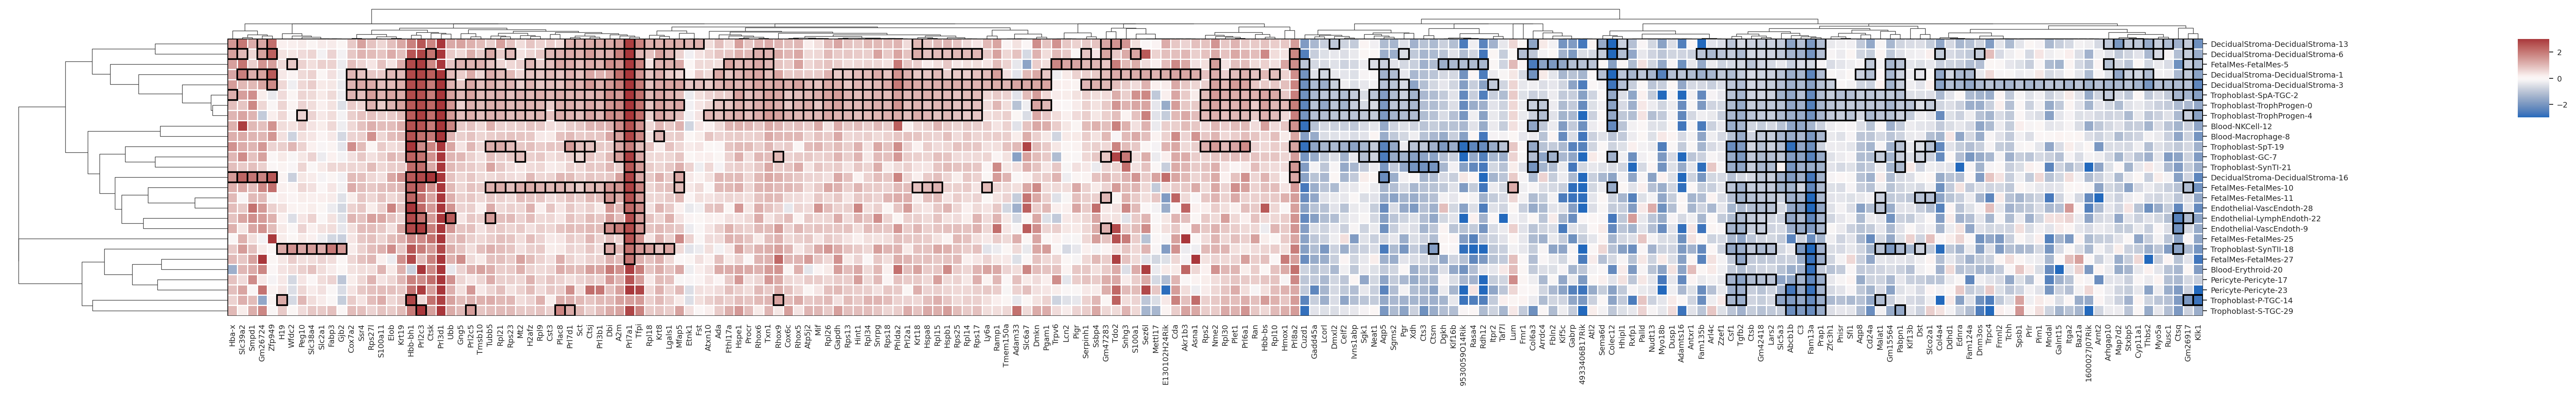

In [ ]:
plot_pydeseq2_results_clustermap_v2(adata, degs, cluster_obs=cluster_obs, values_to_plot='log2FoldChange', key=pydeseq_key,
                                     pval_threshold=0.05, adj_pval_column='padj',
                                     metric='cosine', method='complete', cmap='vlag',
                                     figsize=(40, 5));

### Assemble summary table of pyDESEQ2 results


In [ ]:
import pandas as pd

def filter_and_combine_dfs(dfs, baseMean_threshold=50, log2fc_threshold=1, adj_pvalue_threshold=0.01, gene_col_name="gene"):
    """
    Filters and combines a dictionary of DataFrames while retaining gene names.

    Assumes that gene names are stored as the DataFrame index.

    Parameters:
        dfs (dict): Dictionary where keys are identifiers and values are DataFrames.
        baseMean_threshold (float): Minimum value for the 'baseMean' column.
        log2fc_threshold (float): Minimum value for the 'log2FoldChange' column.
        adj_pvalue_threshold (float): Maximum value for the 'padj' column.
        gene_col_name (str): Column name to assign to the gene names (default is "gene").

    Returns:
        pd.DataFrame: A single DataFrame containing the filtered rows with added 'cluster' and gene name columns.
    """
    filtered_dfs = []

    for key, df in dfs.items():
        #print(key)
        # Convert the index to a column to retain gene names
        df = df.reset_index().rename(columns={'index': gene_col_name})

        # Add a new column 'cluster' with the current key
        df['cluster'] = key

        # Apply filtering conditions
        filtered = df[
            (df['baseMean'] > baseMean_threshold) &
            (df['log2FoldChange'].abs() > log2fc_threshold) &
            (df['padj'] < adj_pvalue_threshold)
        ]

        filtered_dfs.append(filtered)

    # Combine all filtered DataFrames into a single DataFrame
    combined_df = pd.concat(filtered_dfs, ignore_index=True)

    return combined_df


In [ ]:
pyDESeq2_filt_df = filter_and_combine_dfs(adata.uns['pyDESeq2-250121'].copy())

In [ ]:
pyDESeq2_filt_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Rinaudo-Maltepe-IVF/250121/pyDESeq2_filt_df_250403.csv')

## Overlay a single DEG on the UMAP embedding

In [ ]:
# Plot condition UMAP overlays for select transcripts - use log tpm counts layer and same colormap range for all
query_gene_list = ['Egln3','Elob','Eloc','Serpine1','Eif4e','Eif4ebp1']
condition_list = ['Control', 'IVF']
layer = 'tpm'
vmin = 0
vmax = 12

with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  for query in query_gene_list:
    tpm_counts = sc.get.obs_df(adata, query, layer='tpm')
    #vmax = math.ceil(np.max(tpm_counts)); print(vmax)
    for condition in condition_list:
      ax = sc.pl.umap(adata, color=None, size=20, show=False, vmin=vmin, vmax=vmax, layer=layer)
      ax = sc.pl.umap(adata[adata.obs['condition'] == condition], size=10, color=query, color_map='viridis', title=condition+'-'+query, vmin=vmin, vmax=vmax, ax=ax, layer=layer, sort_order=True)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Plot condition UMAP overlays for select transcripts - use log tpm counts layer and same colormap range for all
query_gene_list = ['Prl3d1','Prl7a1','Prl2c3','Tfpi','Hbb-bh1']
condition_list = ['Control', 'IVF']
layer = 'tpm'
vmin = 0
vmax = 12

with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  for query in query_gene_list:
    tpm_counts = sc.get.obs_df(adata, query, layer='tpm')
    #vmax = math.ceil(np.max(tpm_counts)); print(vmax)
    for condition in condition_list:
      ax = sc.pl.umap(adata, color=None, size=20, show=False, vmin=vmin, vmax=vmax, layer=layer)
      ax = sc.pl.umap(adata[adata.obs['condition'] == condition], size=10, color=query, color_map='viridis', title=condition+'-'+query, vmin=vmin, vmax=vmax, ax=ax, layer=layer, sort_order=True)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Plot condition UMAP overlays for select transcripts - use log tpm counts layer
query_gene_list = ['A2m','Adam33','Celf2','Colec12','Csf1','Ctsb','Ctsk','Ednra','Fam13a','H19','Hbb-bh1','Lgals1','Mfap5','Phlda2','Pgam1','Pigr','Plet1','Prap1','Slc39a2','Tgfb2','Tfpi','Hhipl1','Rusc1','Fbln2','Col1a1','Col1a2','Col3a1','Col6a3' ]
condition_list = ['Control', 'IVF']
layer = 'tpm'
vmin = 0
#vmax = 12

with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  for query in query_gene_list:
    tpm_counts = sc.get.obs_df(adata, query, layer='tpm')
    vmax = math.ceil(np.max(tpm_counts)); print(vmax)
    for condition in condition_list:
      ax = sc.pl.umap(adata, color=None, size=20, show=False, vmin=vmin, vmax=vmax, layer=layer)
      ax = sc.pl.umap(adata[adata.obs['condition'] == condition], size=10, color=query, color_map='viridis', title=condition+'-'+query, vmin=vmin, vmax=vmax, ax=ax, layer=layer, sort_order=True)


Output hidden; open in https://colab.research.google.com to view.

## Differential abundance testing - scCoda (Coarse)

In [ ]:
!pip install -q sccoda

In [ ]:
import sccoda as scc
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
import pandas as pd

In [ ]:
# Get crosstab of cell type clusters vs conditions
counts_df = pd.crosstab((adata.obs['library_id']),(adata.obs['Annot_celltype']))
counts_df['condition']=counts_df.index.str.replace(r'[0-9]', '', regex=True).str.replace(r'FB', 'Control', regex=True)
counts_df.head(10 )

Annot_celltype  Blood  DecidualStroma  Endothelial  FetalMes  Pericyte  \
library_id                                                               
FB1              1255            1914          528      1120       417   
FB2               898            1316          482       884       294   
FB3               425            1218          169       714        97   
IVF1             1331            1467          334       927       440   
IVF2              464            2275          427       588       136   
IVF3              738            2305          305       565       165   

Annot_celltype  Trophoblast condition  
library_id                             
FB1                    5200   Control  
FB2                    2553   Control  
FB3                    1218   Control  
IVF1                   4149       IVF  
IVF2                   1638       IVF  
IVF3                   2188       IVF

In [ ]:
# Convert data to anndata object
data_all = scc.util.cell_composition_data.from_pandas(counts_df, covariate_columns=['condition'])
data_all.obs

Annot_celltype condition
library_id              
FB1              Control
FB2              Control
FB3              Control
IVF1                 IVF
IVF2                 IVF
IVF3                 IVF

/usr/local/lib/python3.10/dist-packages/sccoda/util/data_visualization.py:335: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types, rotation=90)


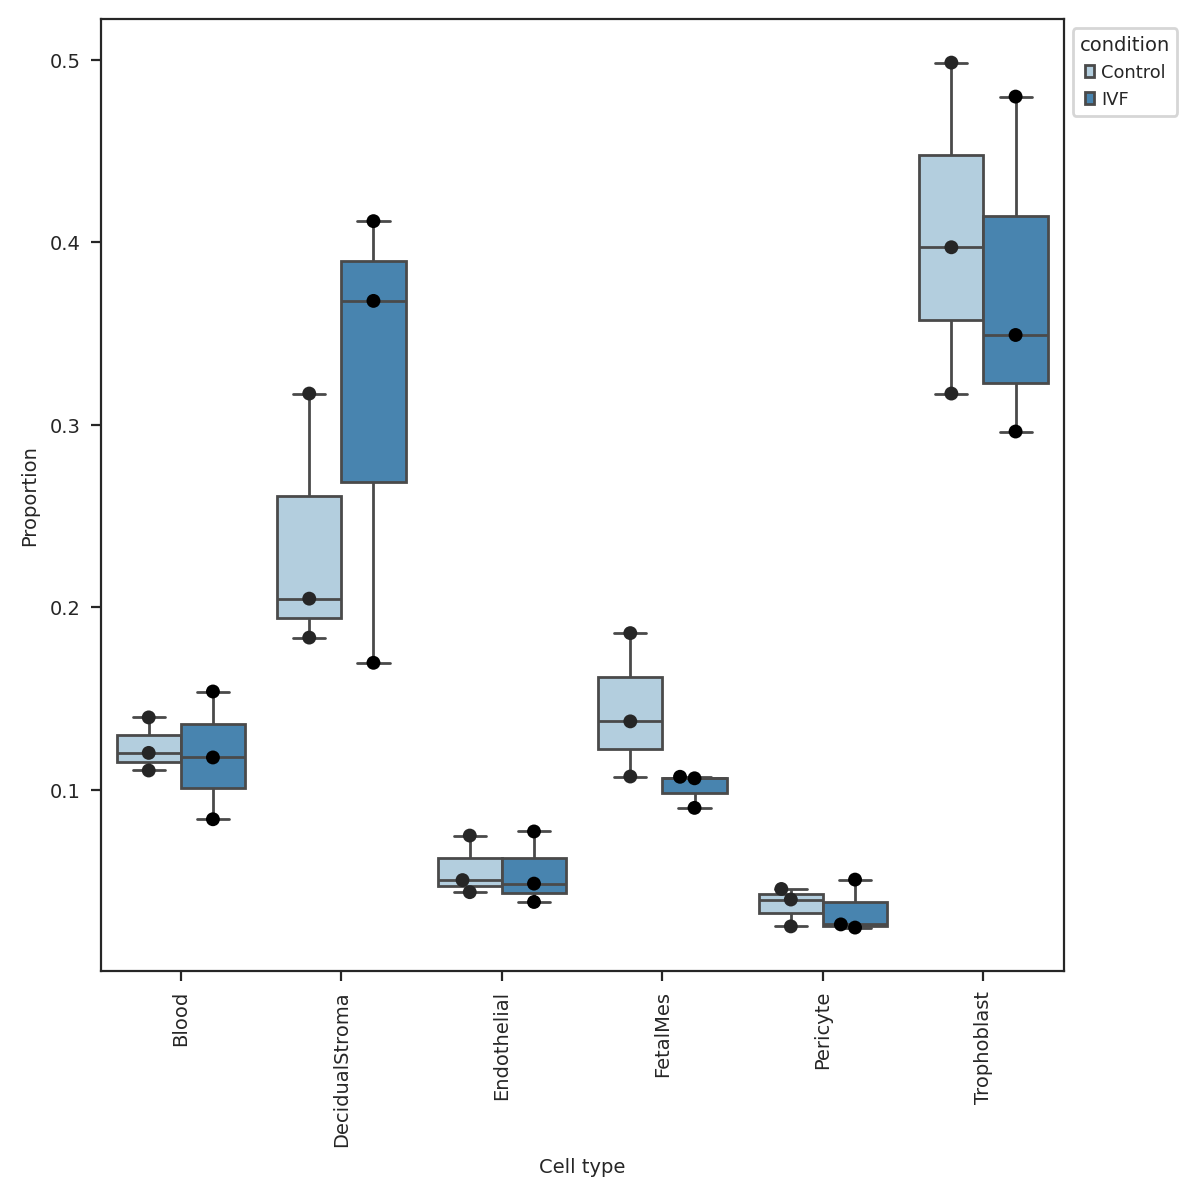

In [ ]:
# Plot proportions
with plt.rc_context({'figure.figsize': (6, 6)}):
  scc.util.data_visualization.boxplots(data_all, feature_name='condition', add_dots=True)
  plt.show()

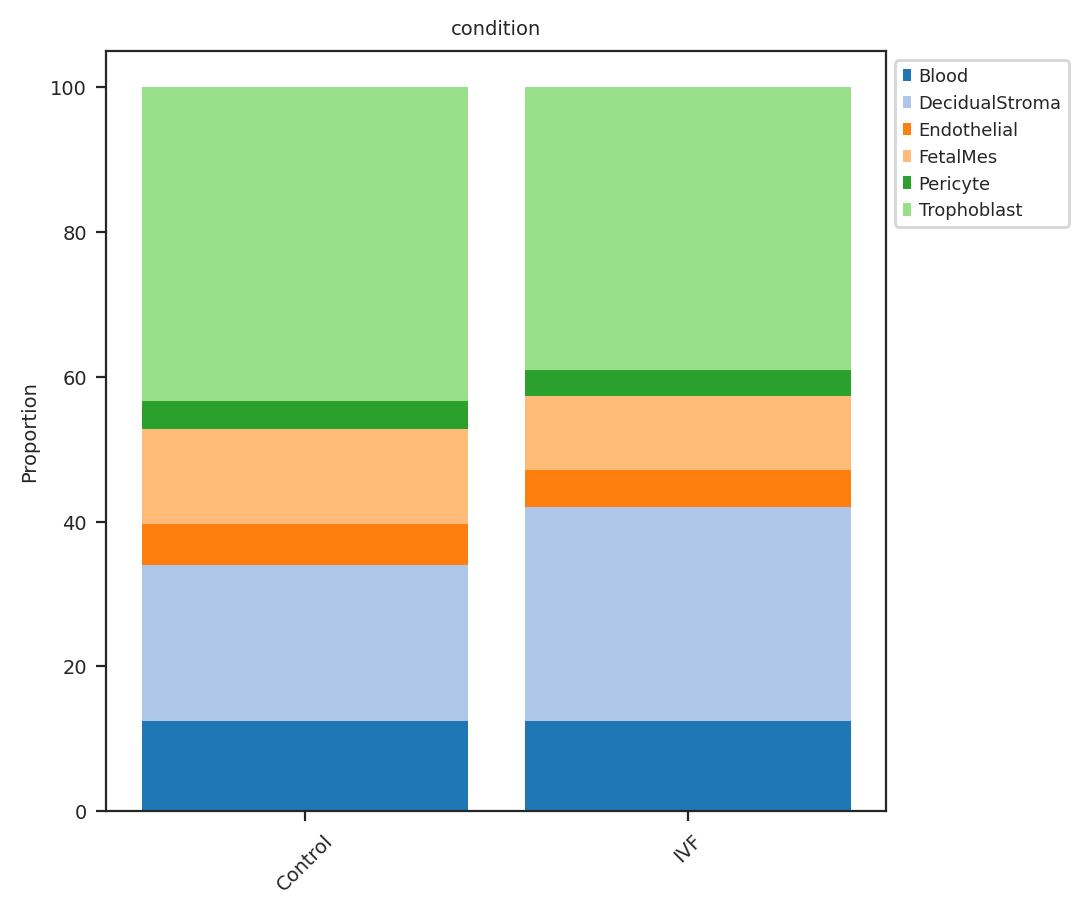

In [ ]:
# Stacked barplot for each sample
with plt.rc_context({'figure.figsize': (5, 5)}):
  scc.util.data_visualization.stacked_barplot(data_all, feature_name='condition')
  plt.show()

In [ ]:
# Initialize model
model_scc = scc.util.comp_ana.CompositionalAnalysis(data_all, formula='condition', reference_cell_type='Endothelial')

### Run w/ Hamiltonian Monte Carlo (HMC) sampling


In [ ]:
# Run w/ Hamiltonian Monte Carlo (HMC) sampling
sim_results = model_scc.sample_hmc(verbose=True)

100%|██████████| 20000/20000 [01:53<00:00, 176.99it/s]


MCMC sampling finished. (144.318 sec)
Acceptance rate: 51.2%


In [ ]:
# Print results summary to screen
sim_results.set_fdr(est_fdr=0.4) #  <- FDR stringency is relaxed quite a bit here
results_df = pd.concat([sim_results.effect_df, pd.DataFrame(sim_results.credible_effects())], axis=1)
results_df.sort_values('Inclusion probability', ascending=False).head(30)

Final Parameter  HDI 3%  HDI 97%     SD  \
Covariate        Cell Type                                                 
condition[T.IVF] DecidualStroma              0.0  -0.119    0.598  0.166   
                 FetalMes                    0.0  -0.618    0.201  0.178   
                 Pericyte                    0.0  -0.566    0.449  0.174   
                 Blood                       0.0  -0.406    0.327  0.119   
                 Trophoblast                 0.0  -0.425    0.202  0.103   
                 Endothelial                 0.0   0.000    0.000  0.000   

                                 Inclusion probability  Expected Sample  \
Covariate        Cell Type                                                
condition[T.IVF] DecidualStroma               0.519800      1745.440333   
                 FetalMes                     0.516667       886.040041   
                 Pericyte                     0.454067       273.079276   
                 Blood                        0.427067       857.277905   
                 Trophoblast                  0.418667      2683.191283   
                 Endothelial                  0.000000       412.304495   

                                 log2-fold change  Final Parameter  
Covariate        Cell Type                                          
condition[T.IVF] DecidualStroma               0.0            False  
                 FetalMes                     0.0            False  
                 Pericyte                     0.0            False  
                 Blood                        0.0            False  
                 Trophoblast                  0.0            False  
                 Endothelial                  0.0            False

### Run w/ No-U-Turn sampling


In [ ]:
# Run w/ No-U-Turn sampling
nuts_results = model_scc.sample_nuts()

100%|██████████| 10000/10000 [06:39<00:00, 25.03it/s]


MCMC sampling finished. (633.327 sec)
Acceptance rate: 88.7%


In [ ]:
nuts_results.set_fdr(est_fdr=0.4) #  <- FDR stringency is relaxed quite a bit here
results_nuts_df = pd.concat([nuts_results.effect_df, pd.DataFrame(nuts_results.credible_effects())], axis=1)
results_nuts_df.sort_values('Inclusion probability', ascending=False).head(30)

Final Parameter  HDI 3%  HDI 97%     SD  \
Covariate        Cell Type                                                 
condition[T.IVF] Pericyte                    0.0  -0.571    0.466  0.188   
                 DecidualStroma              0.0  -0.207    0.570  0.161   
                 Trophoblast                 0.0  -0.386    0.291  0.124   
                 FetalMes                    0.0  -0.695    0.254  0.191   
                 Blood                       0.0  -0.473    0.313  0.130   
                 Endothelial                 0.0   0.000    0.000  0.000   

                                 Inclusion probability  Expected Sample  \
Covariate        Cell Type                                                
condition[T.IVF] Pericyte                       0.5310       271.214091   
                 DecidualStroma                 0.4768      1754.446169   
                 Trophoblast                    0.4642      2686.268978   
                 FetalMes                       0.4534       882.632141   
                 Blood                          0.4474       856.546419   
                 Endothelial                    0.0000       406.225536   

                                 log2-fold change  Final Parameter  
Covariate        Cell Type                                          
condition[T.IVF] Pericyte                     0.0            False  
                 DecidualStroma               0.0            False  
                 Trophoblast                  0.0            False  
                 FetalMes                     0.0            False  
                 Blood                        0.0            False  
                 Endothelial                  0.0            False

## Save fully processed adata

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Rinaudo-Maltepe-IVF/250121/'

In [ ]:
#adata.write(save_path + 'RinaudoMaltepe2023_250121_adata_processed.h5ad', compression='gzip')
adata

AnnData object with n_obs × n_vars = 41144 × 32285
    obs: 'library_id', 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'doublet_score', 'predicted_doublet', 'batch', 'leiden', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'reza', 'dew', 'leiden_dew', 'condition', 'Annot', 'Annot_celltype', 'Annot_subtype', 'Annot_subtype_leiden', 'Annot_cellsubtype_leiden', 'umap_density_condition'
    var: 'gene_ids', 'feature_types', 'mito', 'ribo', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_co

In [ ]:
adata = sc.read(save_path + 'RinaudoMaltepe2023_250121_adata_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 41144 × 32285
    obs: 'library_id', 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'doublet_score', 'predicted_doublet', 'batch', 'leiden', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'reza', 'dew', 'leiden_dew', 'condition', 'Annot', 'Annot_celltype', 'Annot_subtype', 'Annot_subtype_leiden', 'Annot_cellsubtype_leiden', 'umap_density_condition'
    var: 'gene_ids', 'feature_types', 'mito', 'ribo', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_co

In [ ]:
adata.uns['pyDESeq2-250121'].keys()

dict_keys(['Blood-Erythroid-15', 'Blood-Erythroid-20', 'Blood-Erythroid-24', 'Blood-Erythroid-33', 'Blood-Macrophage-8', 'Blood-NKCell-12', 'Blood-Neutrophil-30', 'Blood-TCell-26', 'DecidualStroma-DecidualStroma-1', 'DecidualStroma-DecidualStroma-13', 'DecidualStroma-DecidualStroma-16', 'DecidualStroma-DecidualStroma-3', 'DecidualStroma-DecidualStroma-6', 'Endothelial-LymphEndoth-22', 'Endothelial-VascEndoth-28', 'Endothelial-VascEndoth-9', 'Endothelial-VascEndothSCell-35', 'FetalMes-FetalMes-10', 'FetalMes-FetalMes-11', 'FetalMes-FetalMes-25', 'FetalMes-FetalMes-27', 'FetalMes-FetalMes-5', 'Pericyte-Pericyte-17', 'Pericyte-Pericyte-23', 'Pericyte-Pericyte-31', 'Pericyte-Pericyte-37', 'Trophoblast-GC-7', 'Trophoblast-LaTP-32', 'Trophoblast-LaTP2-34', 'Trophoblast-P-TGC-14', 'Trophoblast-S-TGC-29', 'Trophoblast-SpA-TGC-2', 'Trophoblast-SpT-19', 'Trophoblast-SynTI-21', 'Trophoblast-SynTII-18', 'Trophoblast-TrophProgen-0', 'Trophoblast-TrophProgen-4'])

# ANALYSIS: Trophoblast Subset

## Flag and subset only the trophoblast clusters


In [ ]:
t_flag = adata.obs['leiden'].isin(['0', '2', '4', '7', '14', '18', '19', '21', '29', '32', '34'])
adata_troph = adata[t_flag].copy()
adata_troph

AnnData object with n_obs × n_vars = 16946 × 32285
    obs: 'library_id', 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'doublet_score', 'predicted_doublet', 'batch', 'leiden', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'reza', 'dew', 'leiden_dew', 'condition', 'Annot', 'Annot_celltype', 'Annot_subtype', 'Annot_subtype_leiden', 'Annot_cellsubtype_leiden'
    var: 'gene_ids', 'feature_types', 'mito', 'ribo', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_coun

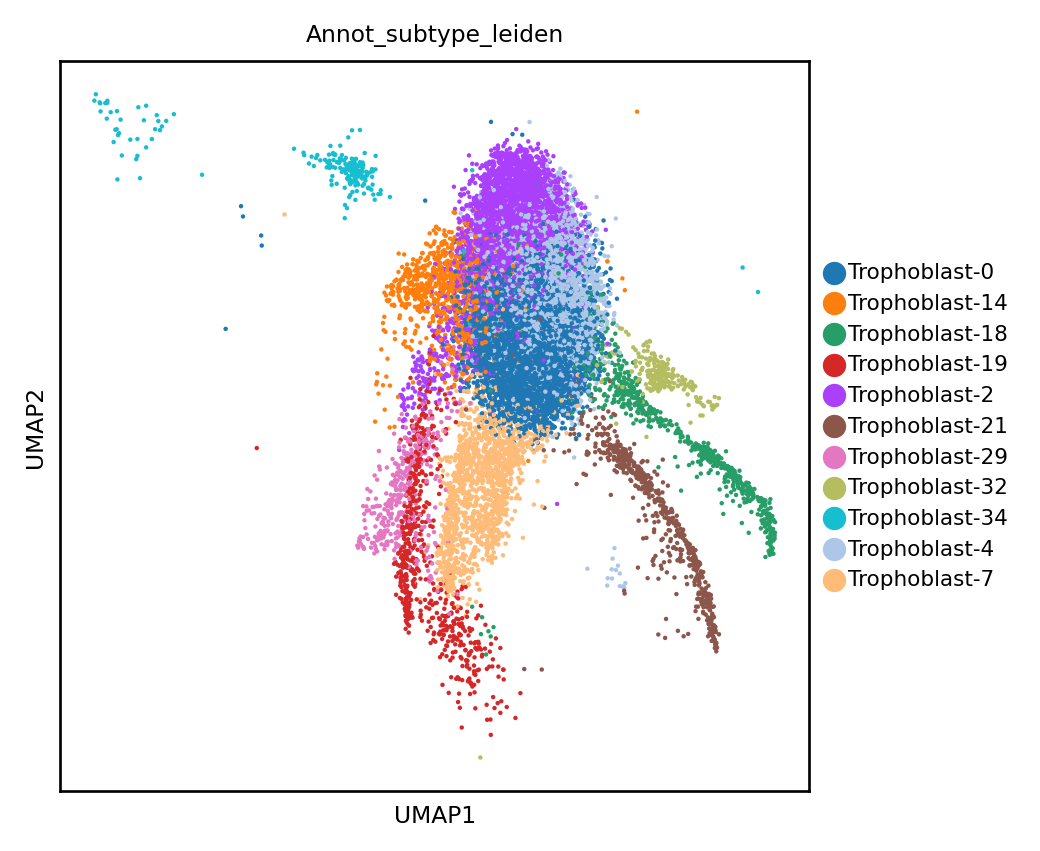

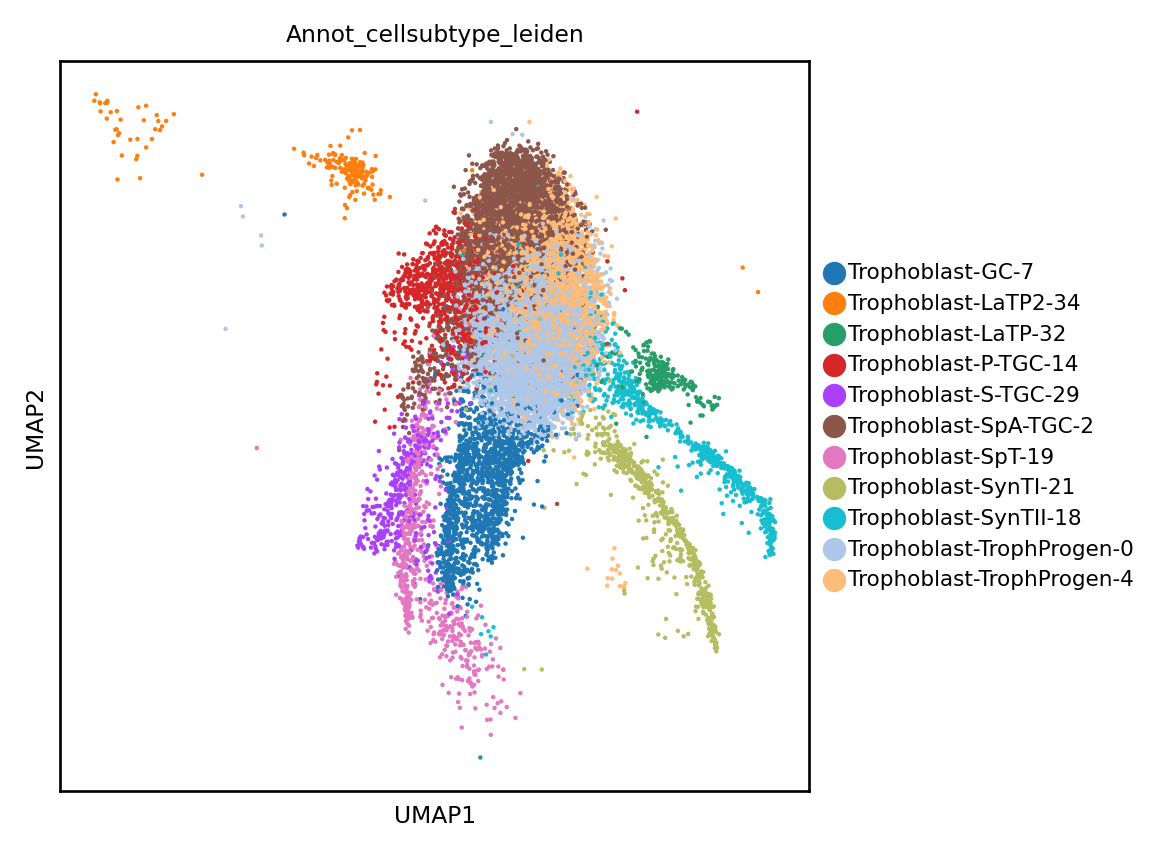

In [ ]:
sc.pl.umap(adata_troph, color='Annot_subtype_leiden')
sc.pl.umap(adata_troph, color='Annot_cellsubtype_leiden')

In [ ]:
adata_troph.X = adata_troph.layers['raw_nolog'].copy()
adata_troph.layers['raw'] = np.log1p(adata_troph.X.copy())
sc.pp.normalize_total(adata_troph, target_sum=1e6, inplace=True) # TPM Normalization
adata_troph.layers['tpm_nolog'] = adata_troph.X.copy()
adata_troph.layers['tpm'] = np.log1p(adata_troph.X.copy())
sc.pp.log1p(adata_troph)
sc.pp.highly_variable_genes(adata_troph, n_top_genes=2000, batch_key='batch')
sc.pp.scale(adata_troph)

Performing PCA on data
Performing PCA on randomized data
Iteration 20 / 20

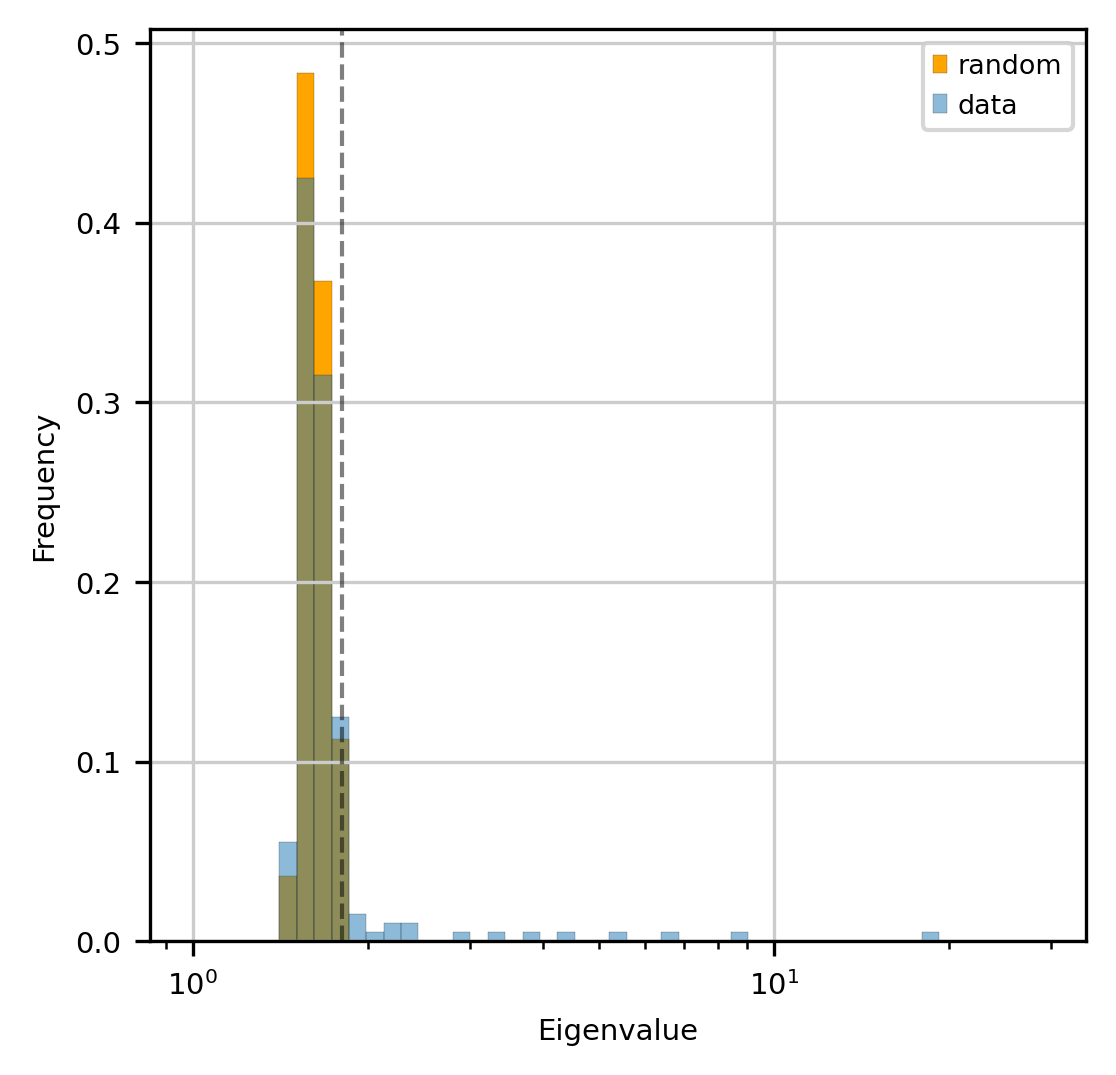

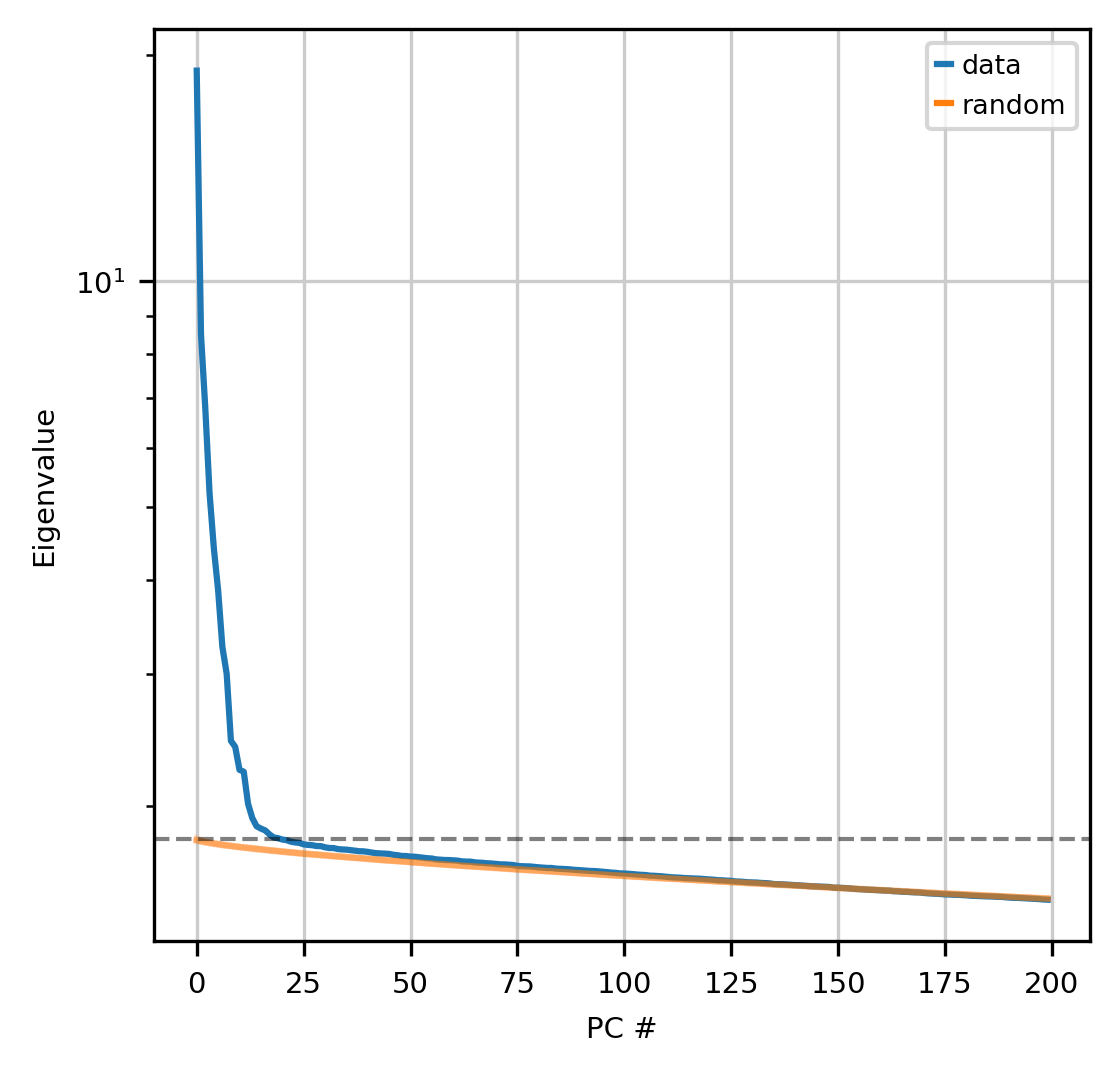

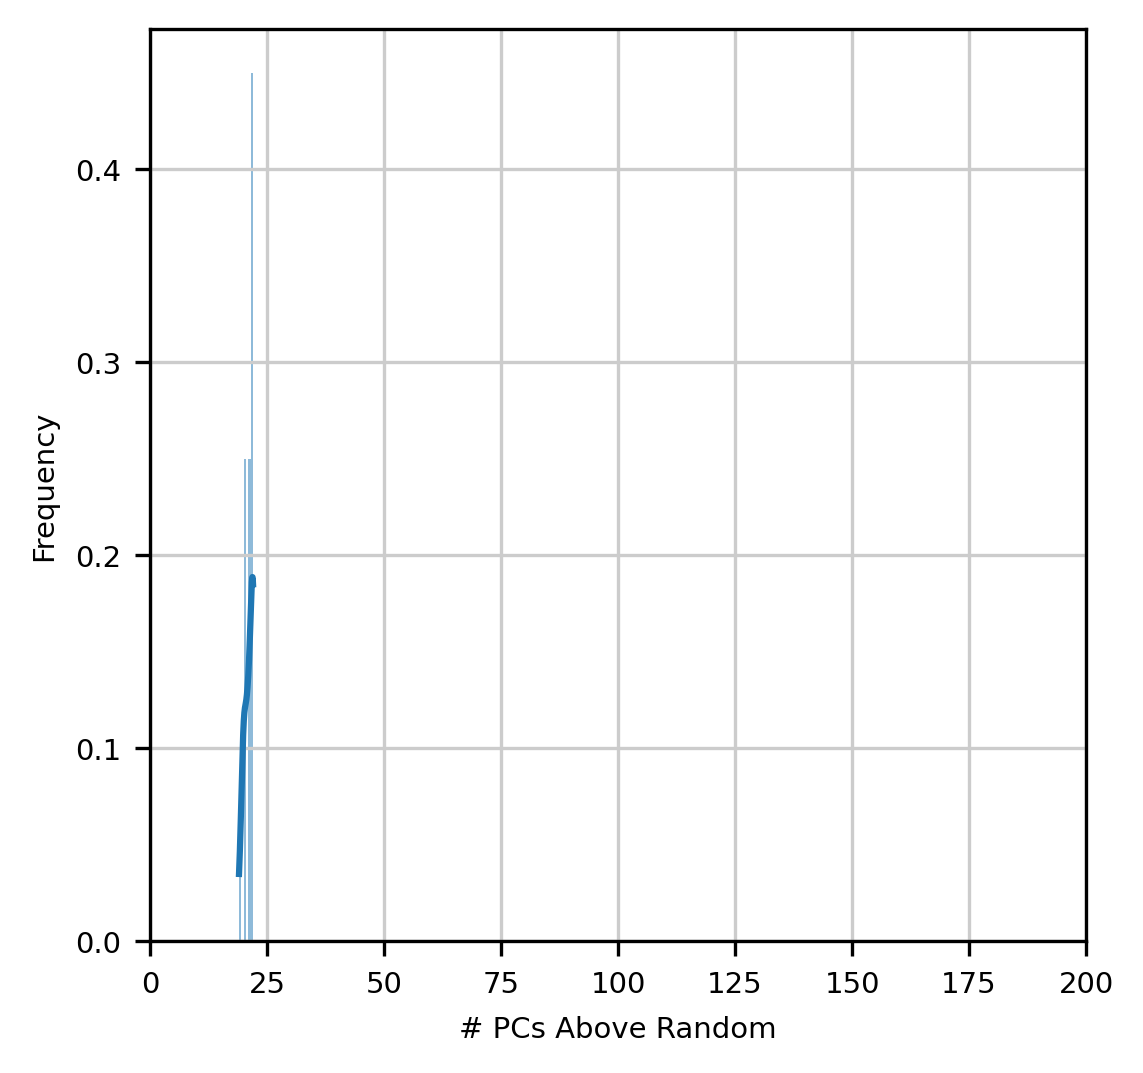


Counting the # of PCs with eigenvalues above random in >95% of trials
Eigenvalue Threshold = 1.81
# Significant PCs = 20


In [ ]:
# Determine # of significant PC dimensions
dew.get_significant_pcs(adata_troph, n_iter = 20, nPCs_test = 200, show_plots = True)

# Alternatively, set the # of dimensions manually
#adata.uns['n_sig_PCs']=150

In [ ]:
adata_troph

AnnData object with n_obs × n_vars = 16946 × 32285
    obs: 'library_id', 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'doublet_score', 'predicted_doublet', 'batch', 'leiden', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'reza', 'dew', 'leiden_dew', 'condition', 'Annot', 'Annot_celltype', 'Annot_subtype', 'Annot_subtype_leiden', 'Annot_cellsubtype_leiden'
    var: 'gene_ids', 'feature_types', 'mito', 'ribo', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_coun

In [ ]:
adata_troph.uns['n_sig_PCs']

20

In [ ]:
# Perform PCA with a specified number of dimensions
sc.pp.pca(adata_troph, n_comps=adata_troph.uns['n_sig_PCs'])

In [ ]:
# Generate the neighbor graph
#sc.pp.neighbors(adata_troph, n_neighbors=15, n_pcs=adata_troph.uns['n_sig_PCs'])

# Harmony Version - perform PCA & generate neighbor graph
sc.external.pp.harmony_integrate(adata_troph, 'batch', basis='X_pca', adjusted_basis='X_pca_harmony')
sc.pp.neighbors(adata_troph, n_neighbors=15, n_pcs=adata_troph.uns['n_sig_PCs'], metric='euclidean', use_rep='X_pca_harmony')

2025-01-27 19:49:42,675 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-01-27 19:49:44,935 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-01-27 19:49:44,994 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-01-27 19:49:51,675 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-01-27 19:49:57,541 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


In [ ]:
# Generate embedding
sc.tl.umap(adata_troph, n_components=2, min_dist=0.5, spread=1, maxiter=500)

## Examine trophoblast subset embedding

In [ ]:
sc.set_figure_params(dpi=150, figsize=[4,4], fontsize=7)
sc.pl.umap(adata_troph, color=['Annot_celltype'])
sc.pl.umap(adata_troph, color=['leiden'])
sc.pl.umap(adata_troph, color=['condition'])
sc.pl.umap(adata_troph, color=['Annot_subtype'])
sc.pl.umap(adata_troph, color=['Annot_subtype'], legend_loc='on data')

Output hidden; open in https://colab.research.google.com to view.

## Get trophoblast subset differential embedding density

In [ ]:
sc.tl.embedding_density(adata_troph, basis='umap', groupby='condition', key_added='condition_density')

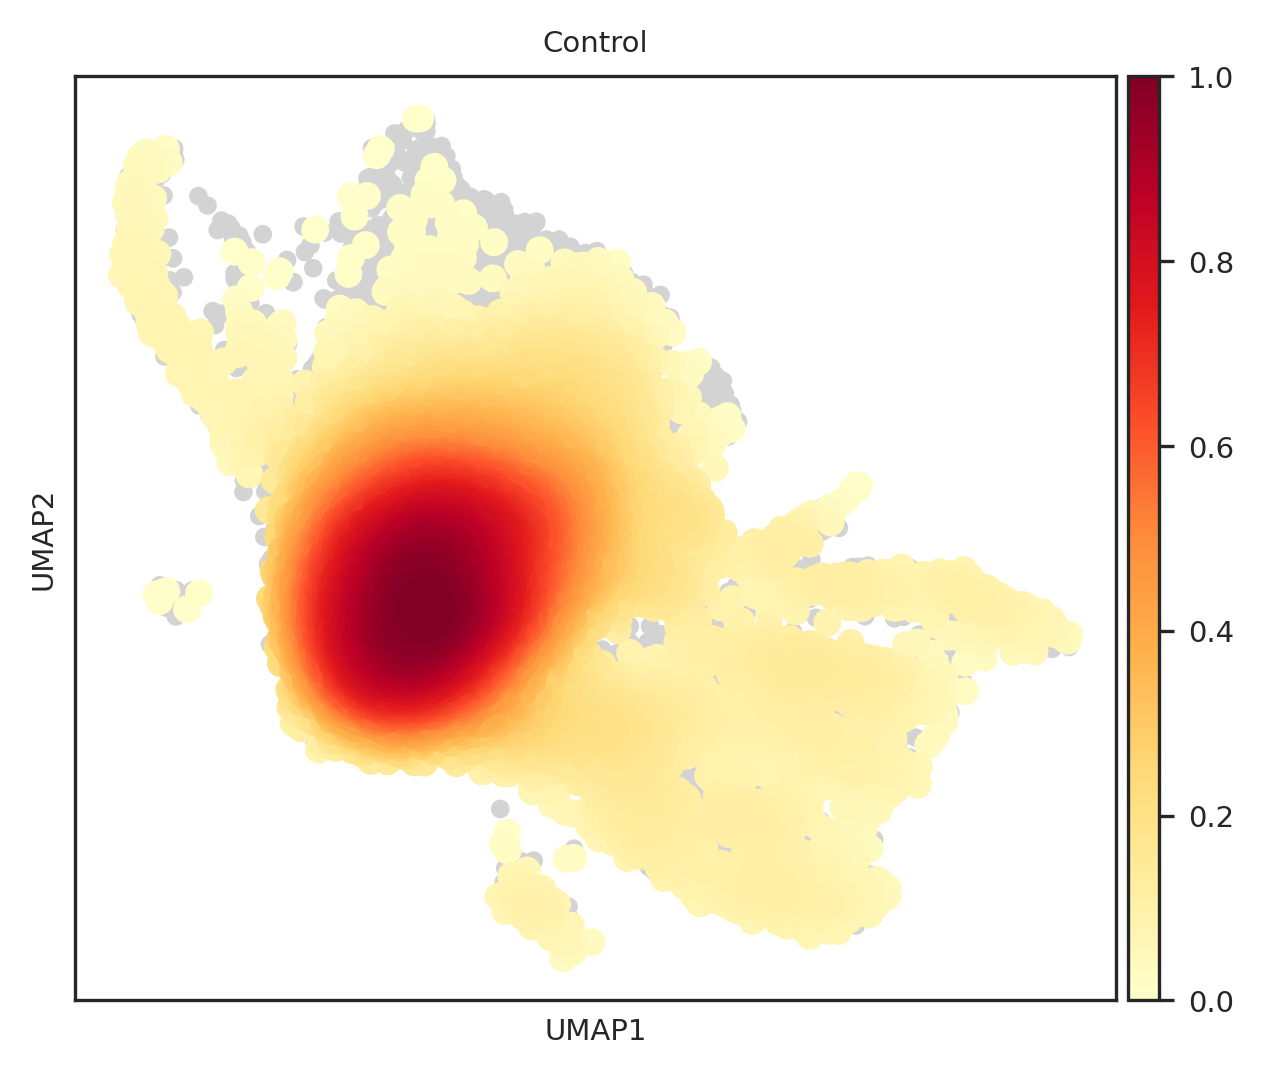

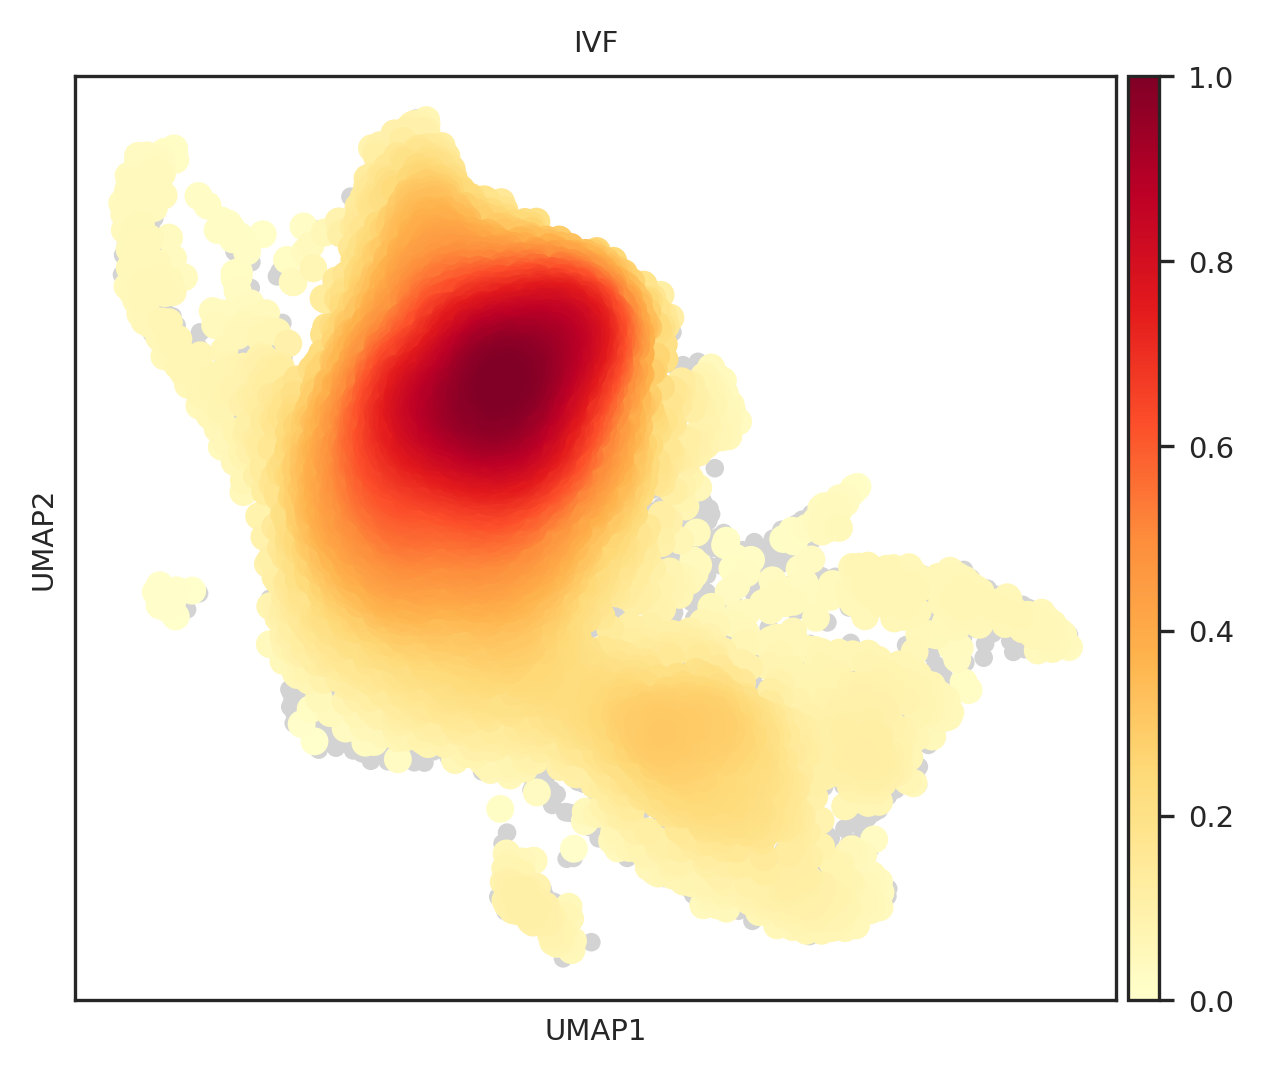

In [ ]:
sc.pl.embedding_density(adata_troph, basis='umap', key='condition_density', group='Control')
sc.pl.embedding_density(adata_troph, basis='umap', key='condition_density', group='IVF')

## Get trophoblast subset cluster markers


In [ ]:
sc.tl.rank_genes_groups(adata_troph,
                        'Annot_subtype',
                        layer='raw',
                        log_transformed=True,
                        n_genes=100,
                        reference='rest',
                        method='wilcoxon',
                        corr_method='benjamini-hochberg')

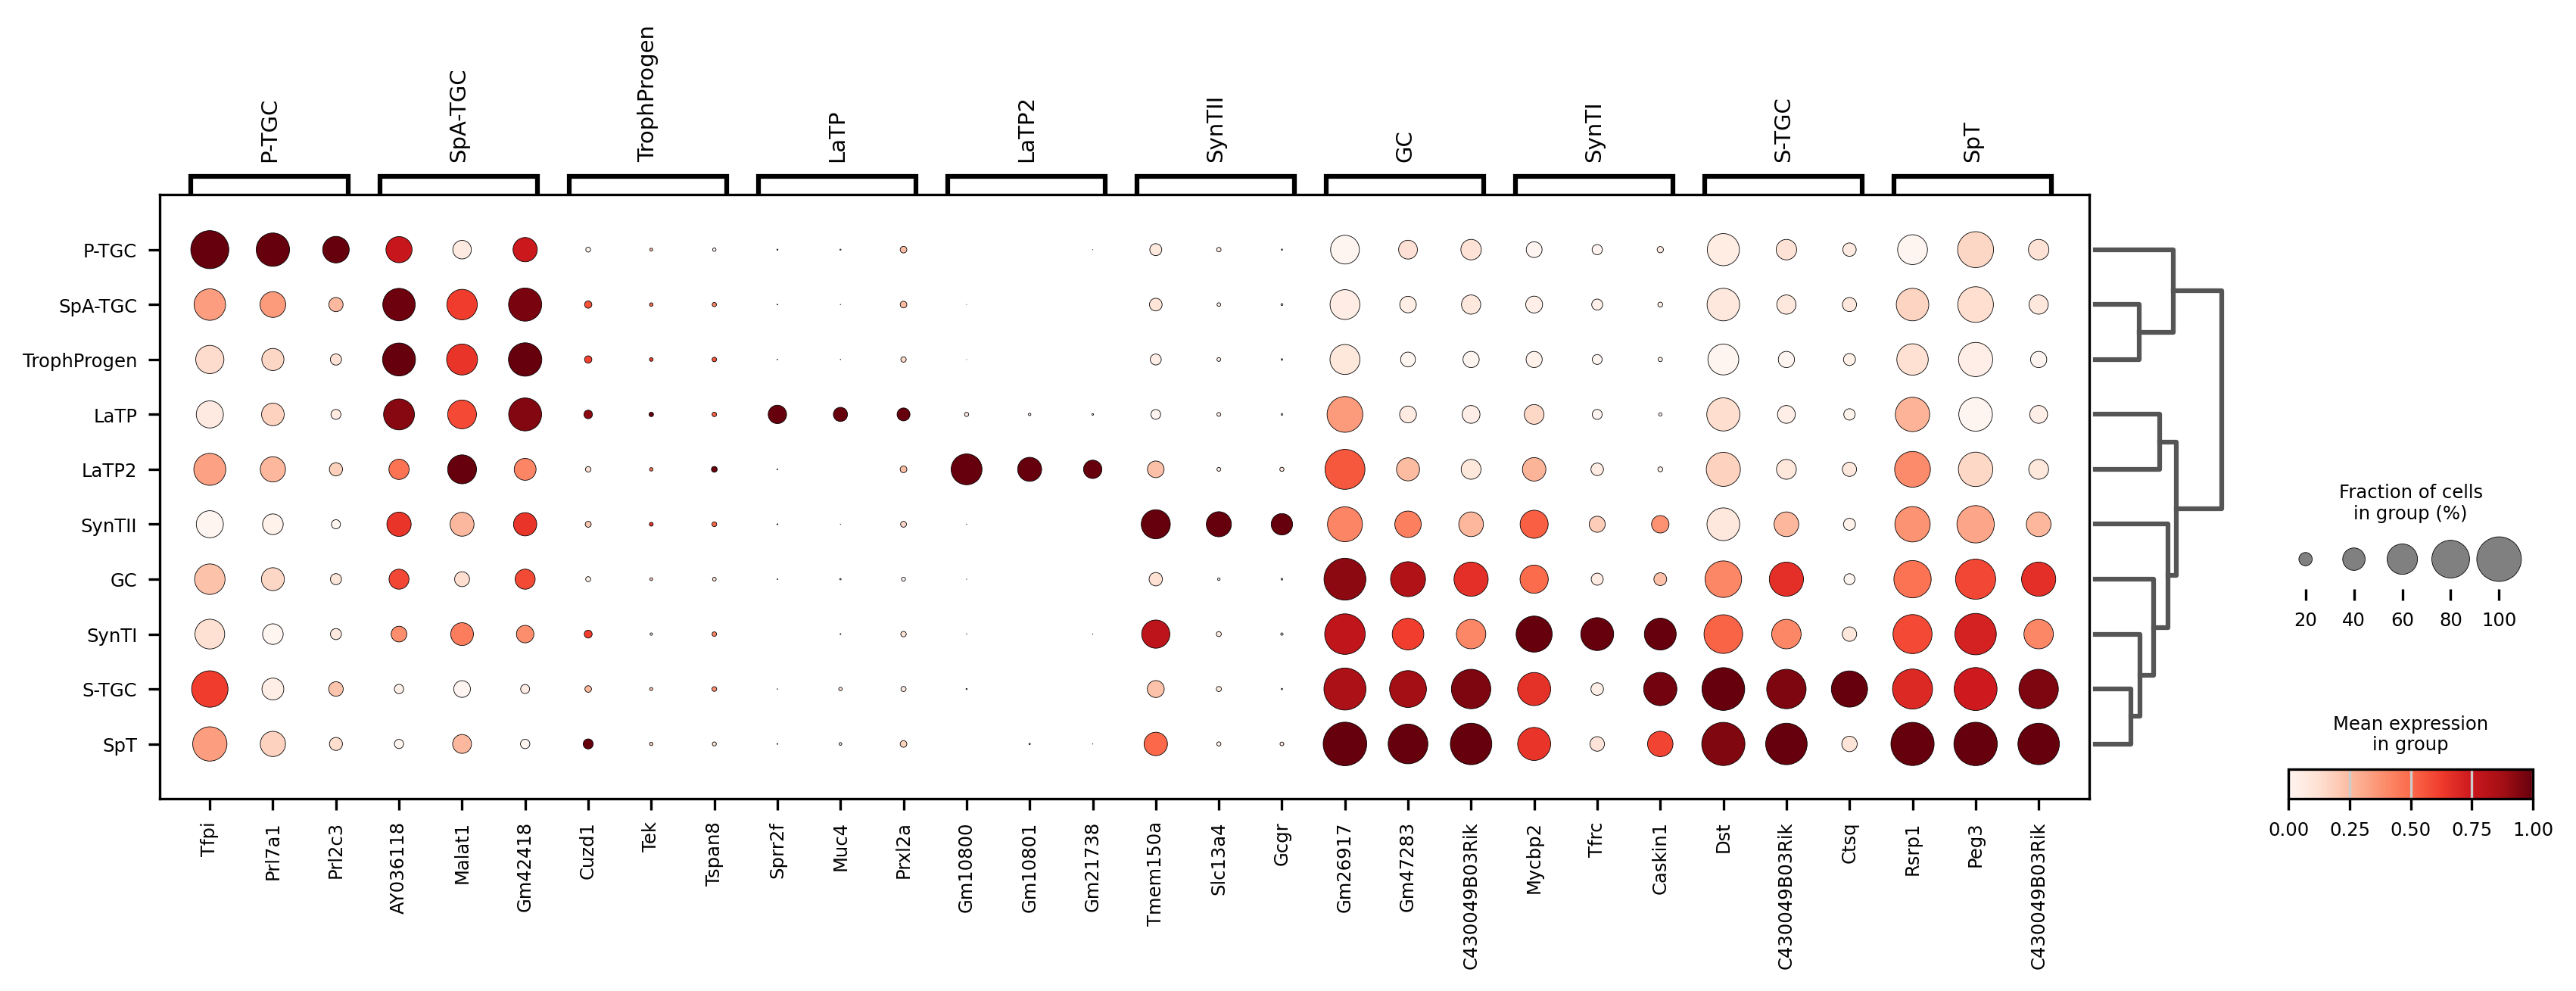

In [ ]:
#del adata_troph.uns['dendrogram_Annot_subtype']
sc.pl.rank_genes_groups_dotplot(adata_troph, n_genes=3, standard_scale='var');

In [ ]:
dew.get_deg_table(adata_troph, ngenes_csv=100, ngenes_disp=10, thresh_pv=1, thresh_logfc=0)

GC    LaTP    LaTP2   P-TGC          S-TGC   SpA-TGC  \
0        Gm26917  Sprr2f  Gm10800    Tfpi            Dst  AY036118   
1        Gm47283    Muc4  Gm10801  Prl7a1  C430049B03Rik    Malat1   
2  C430049B03Rik          Gm21738  Prl2c3           Ctsq   Gm42418   
3          Rbm25          Gm26917     H19          N4bp2     Prap1   
4            Son            Neat1  Prl2c5         Fnd3c2      Gpx3   
5          Srrm2           Malat1   Krt18          Rbm25     Tpbpa   
6          Rbm39            Srrm2    Krt8           Wnk1    Hba-a1   
7            Fus             Pbx1  Prl3b1          Map1b    Ctla2a   
8           Peg3              Fus  Prl7d1          Trrap    Col4a1   
9          Taf1d            Grina    Ctsj           Brd3    Prl7d1   

             SpT    SynTI    SynTII TrophProgen  
0          Rsrp1   Mycbp2  Tmem150a              
1           Peg3     Tfrc   Slc13a4              
2  C430049B03Rik  Caskin1      Gcgr              
3          Rbm39  Gm26917   Plekha7              
4          Rbm25    Macf1     Vegfa              
5        Gm26917  Slc38a1      Gjb2              
6           Flt1    Ahnak     Apela              
7            Dst     Wnk3    Slc4a2              
8         Pappa2     Car4    Abcb1b              
9            Fn1    Kmt2c     Wfdc2

## Split violins: a single DEG vs trophoblast clusters

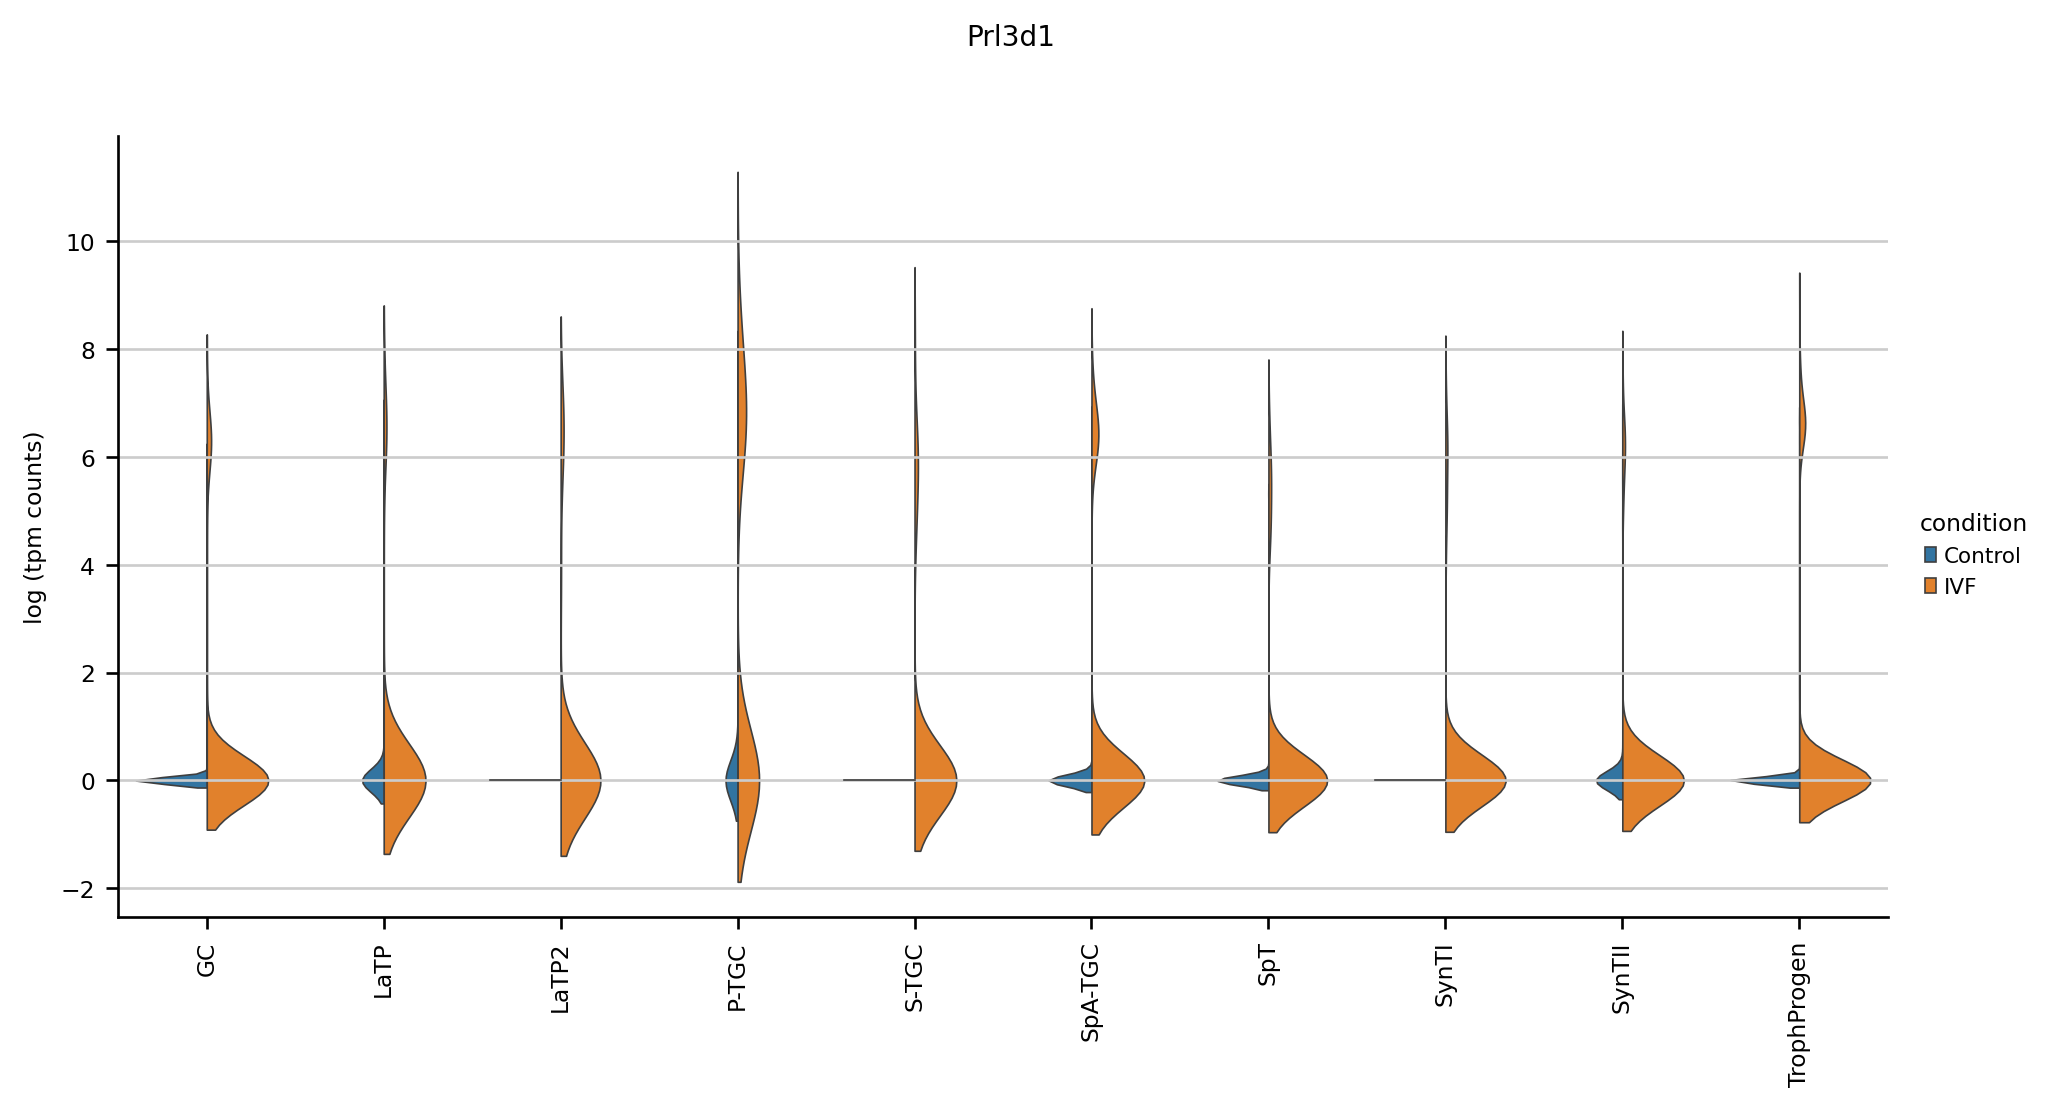

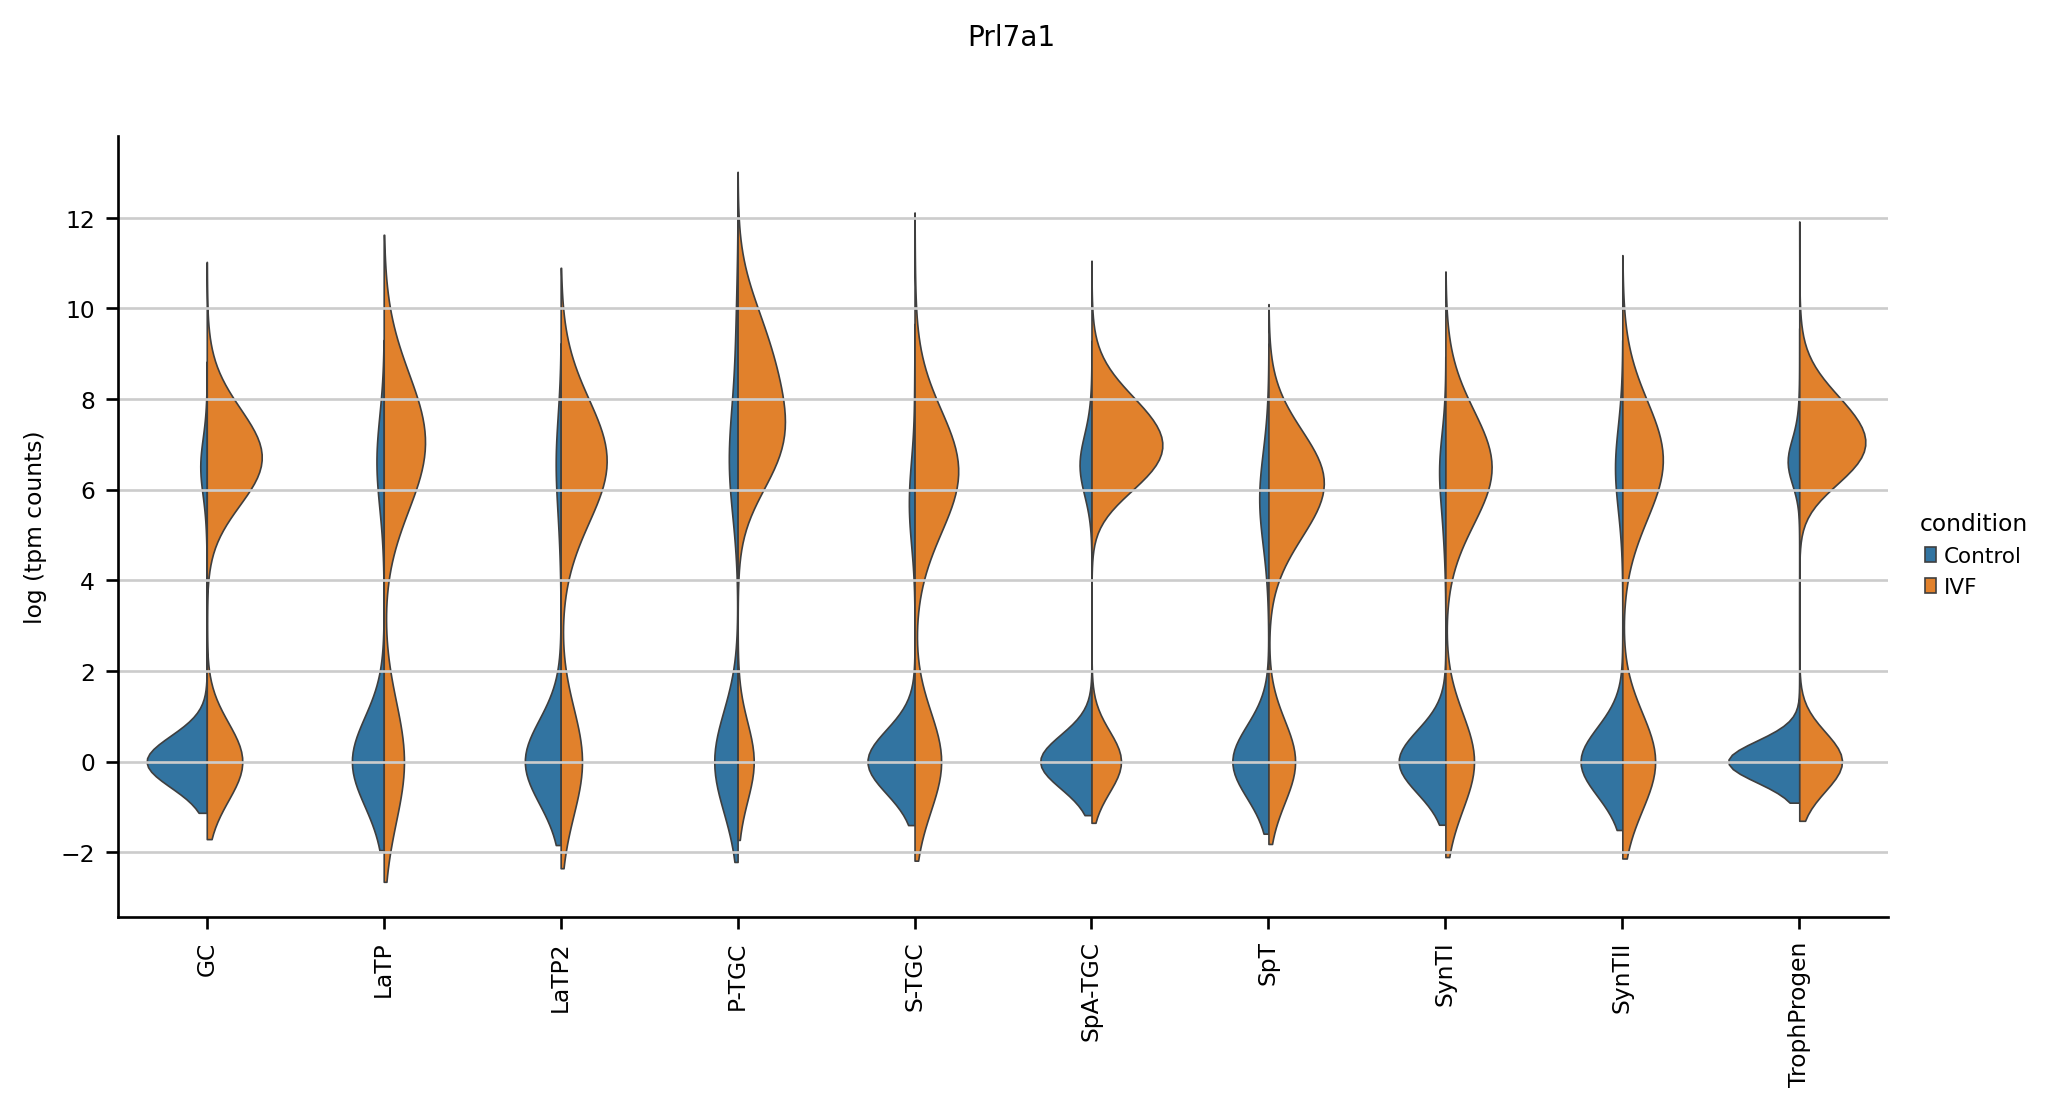

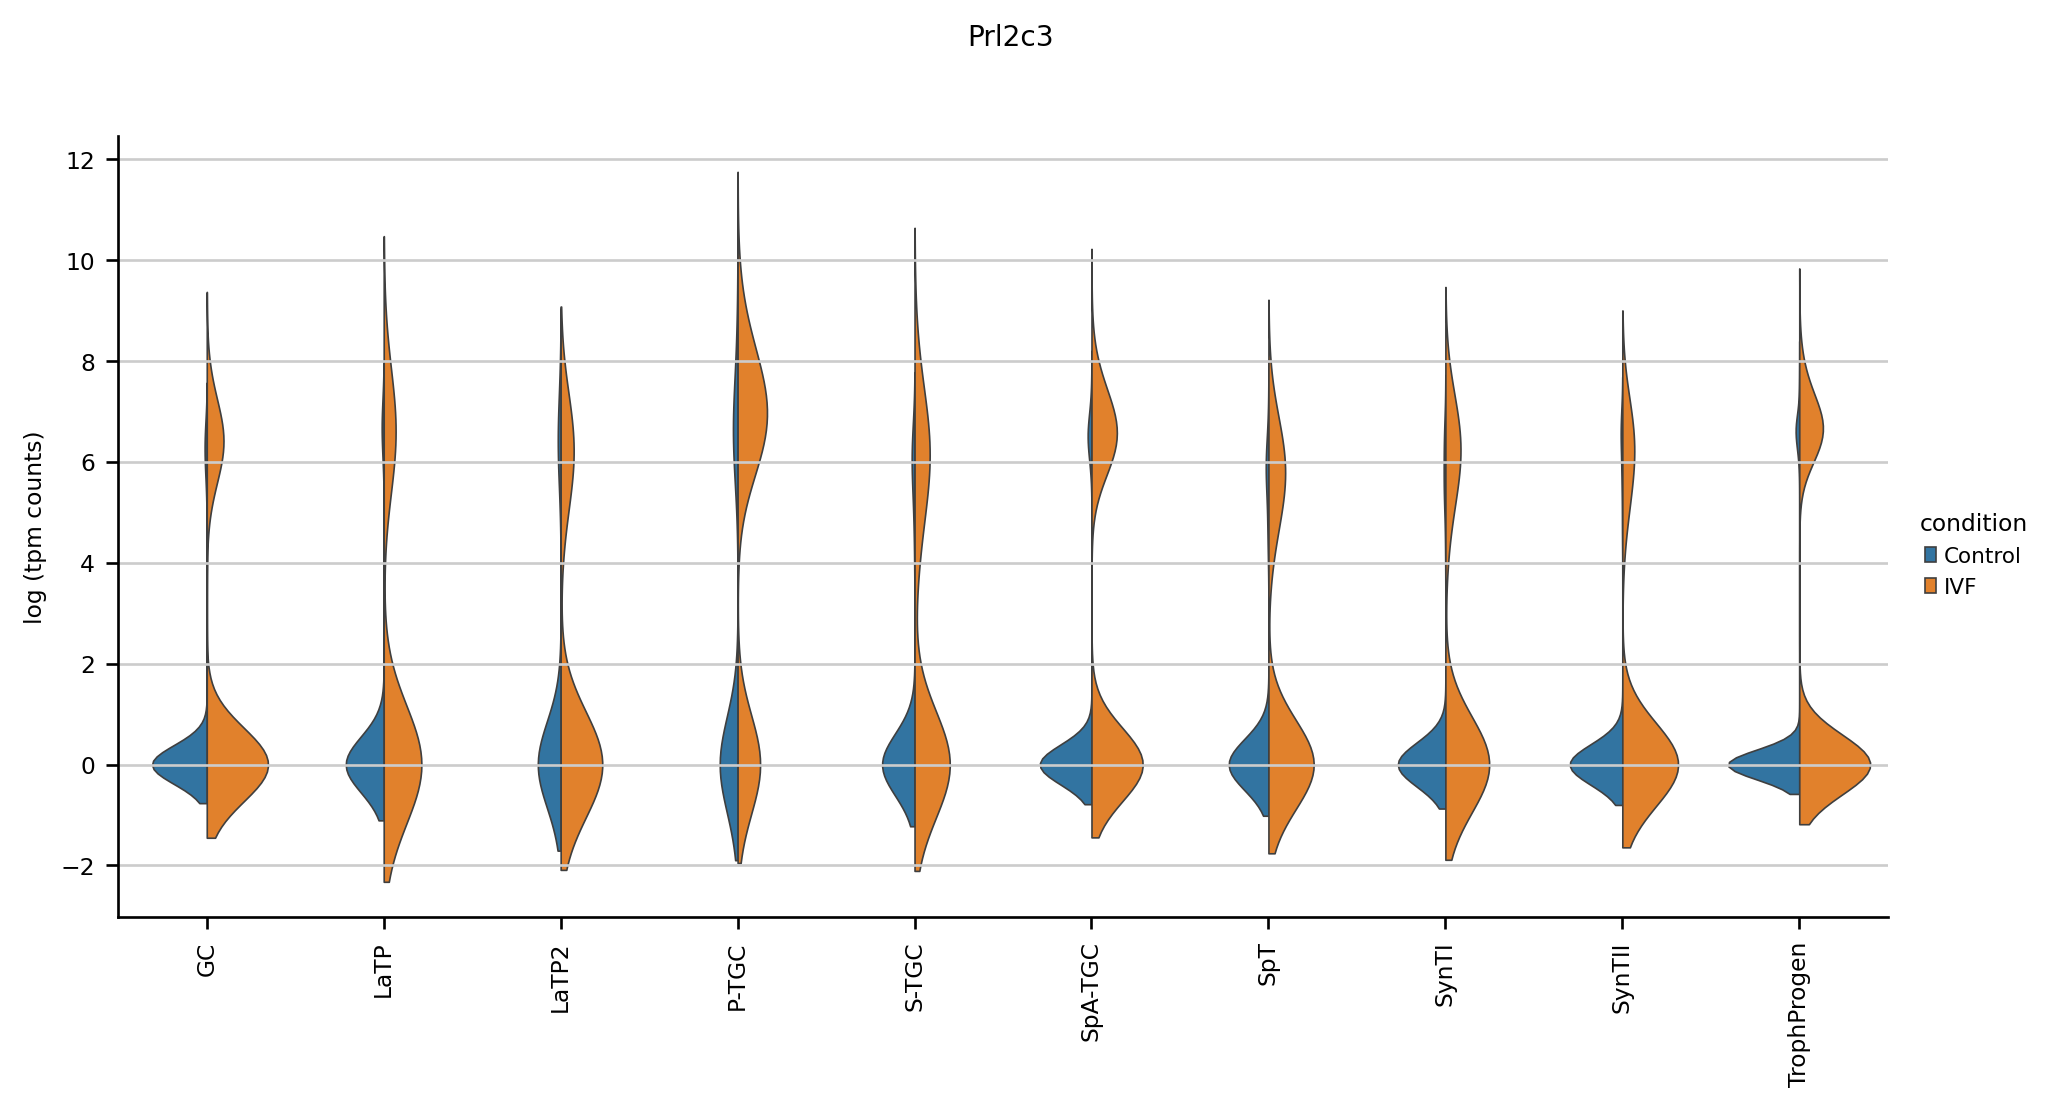

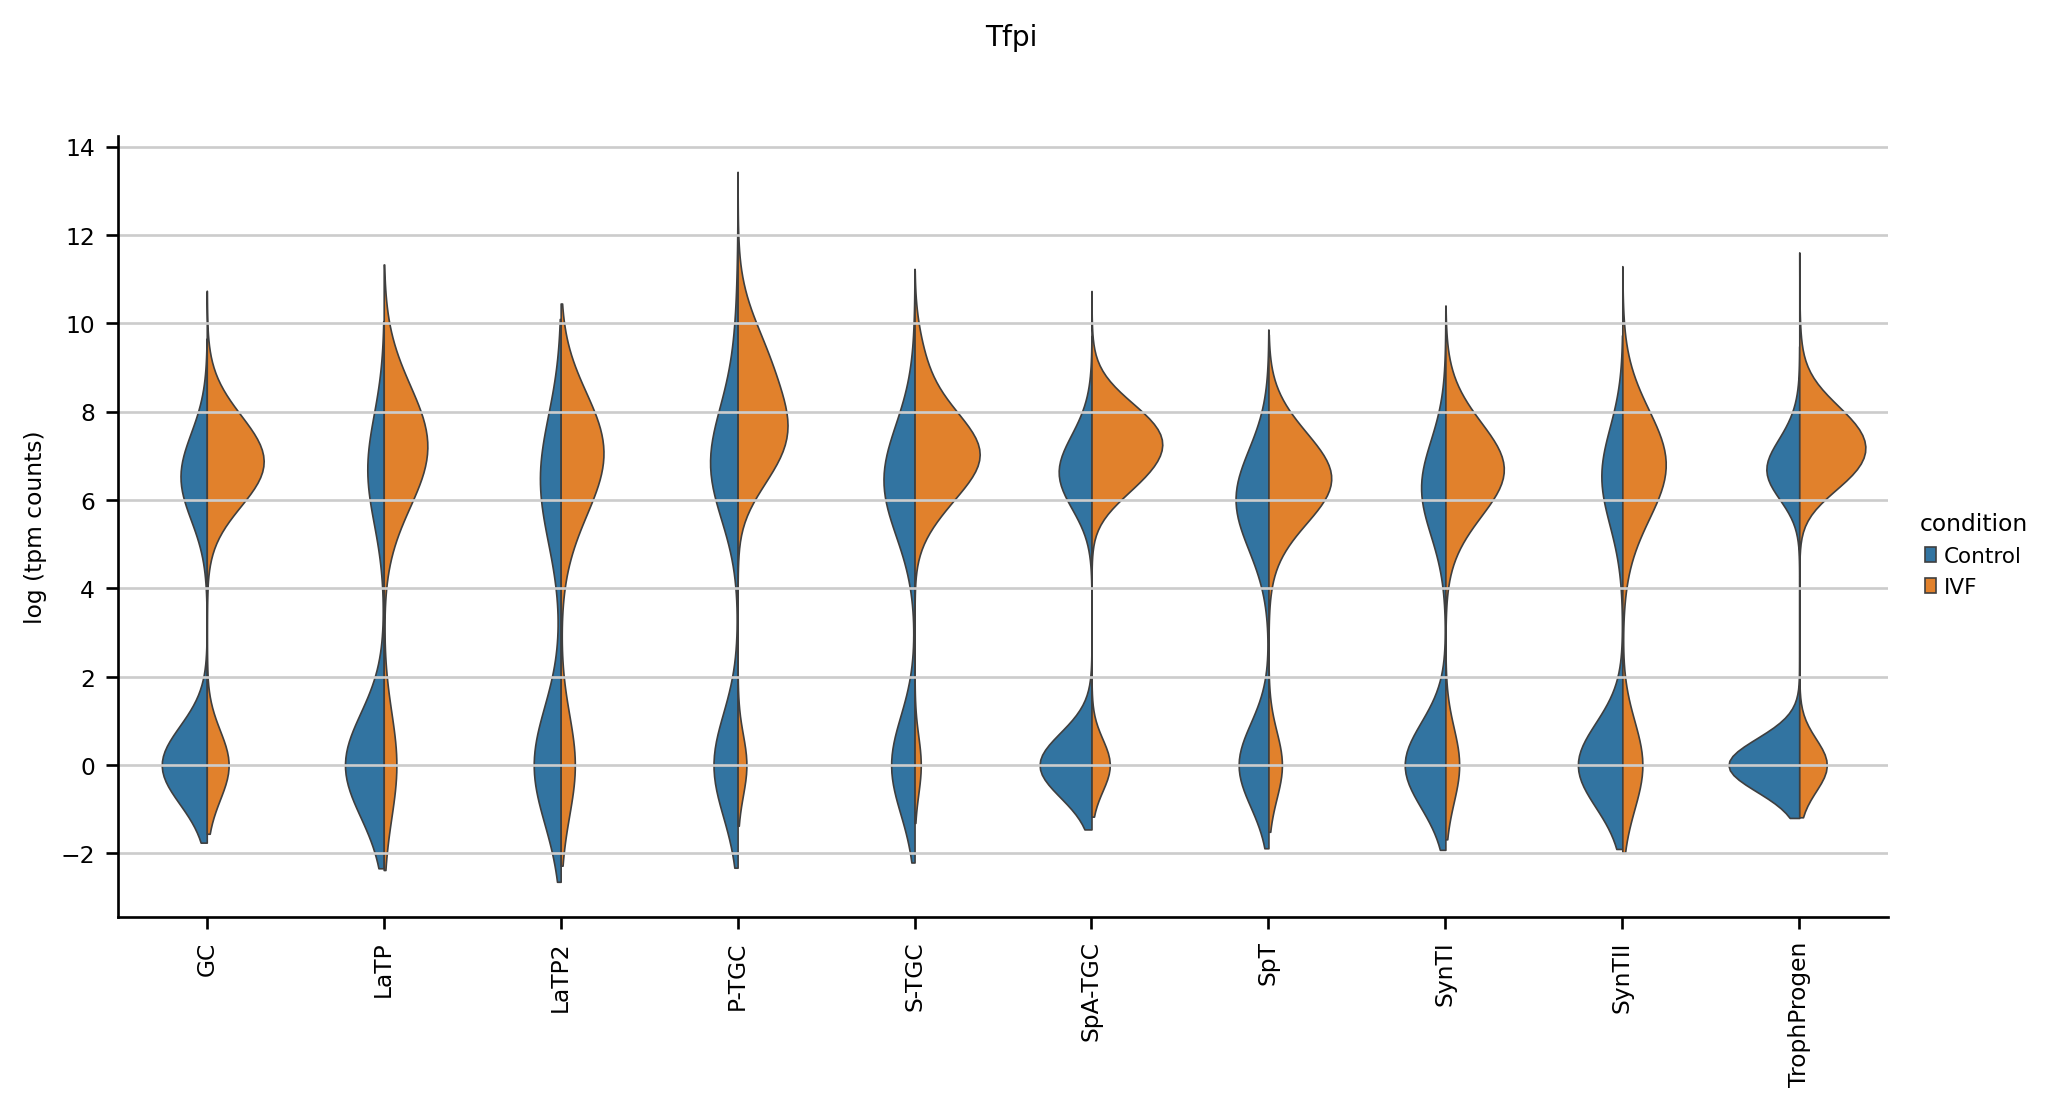

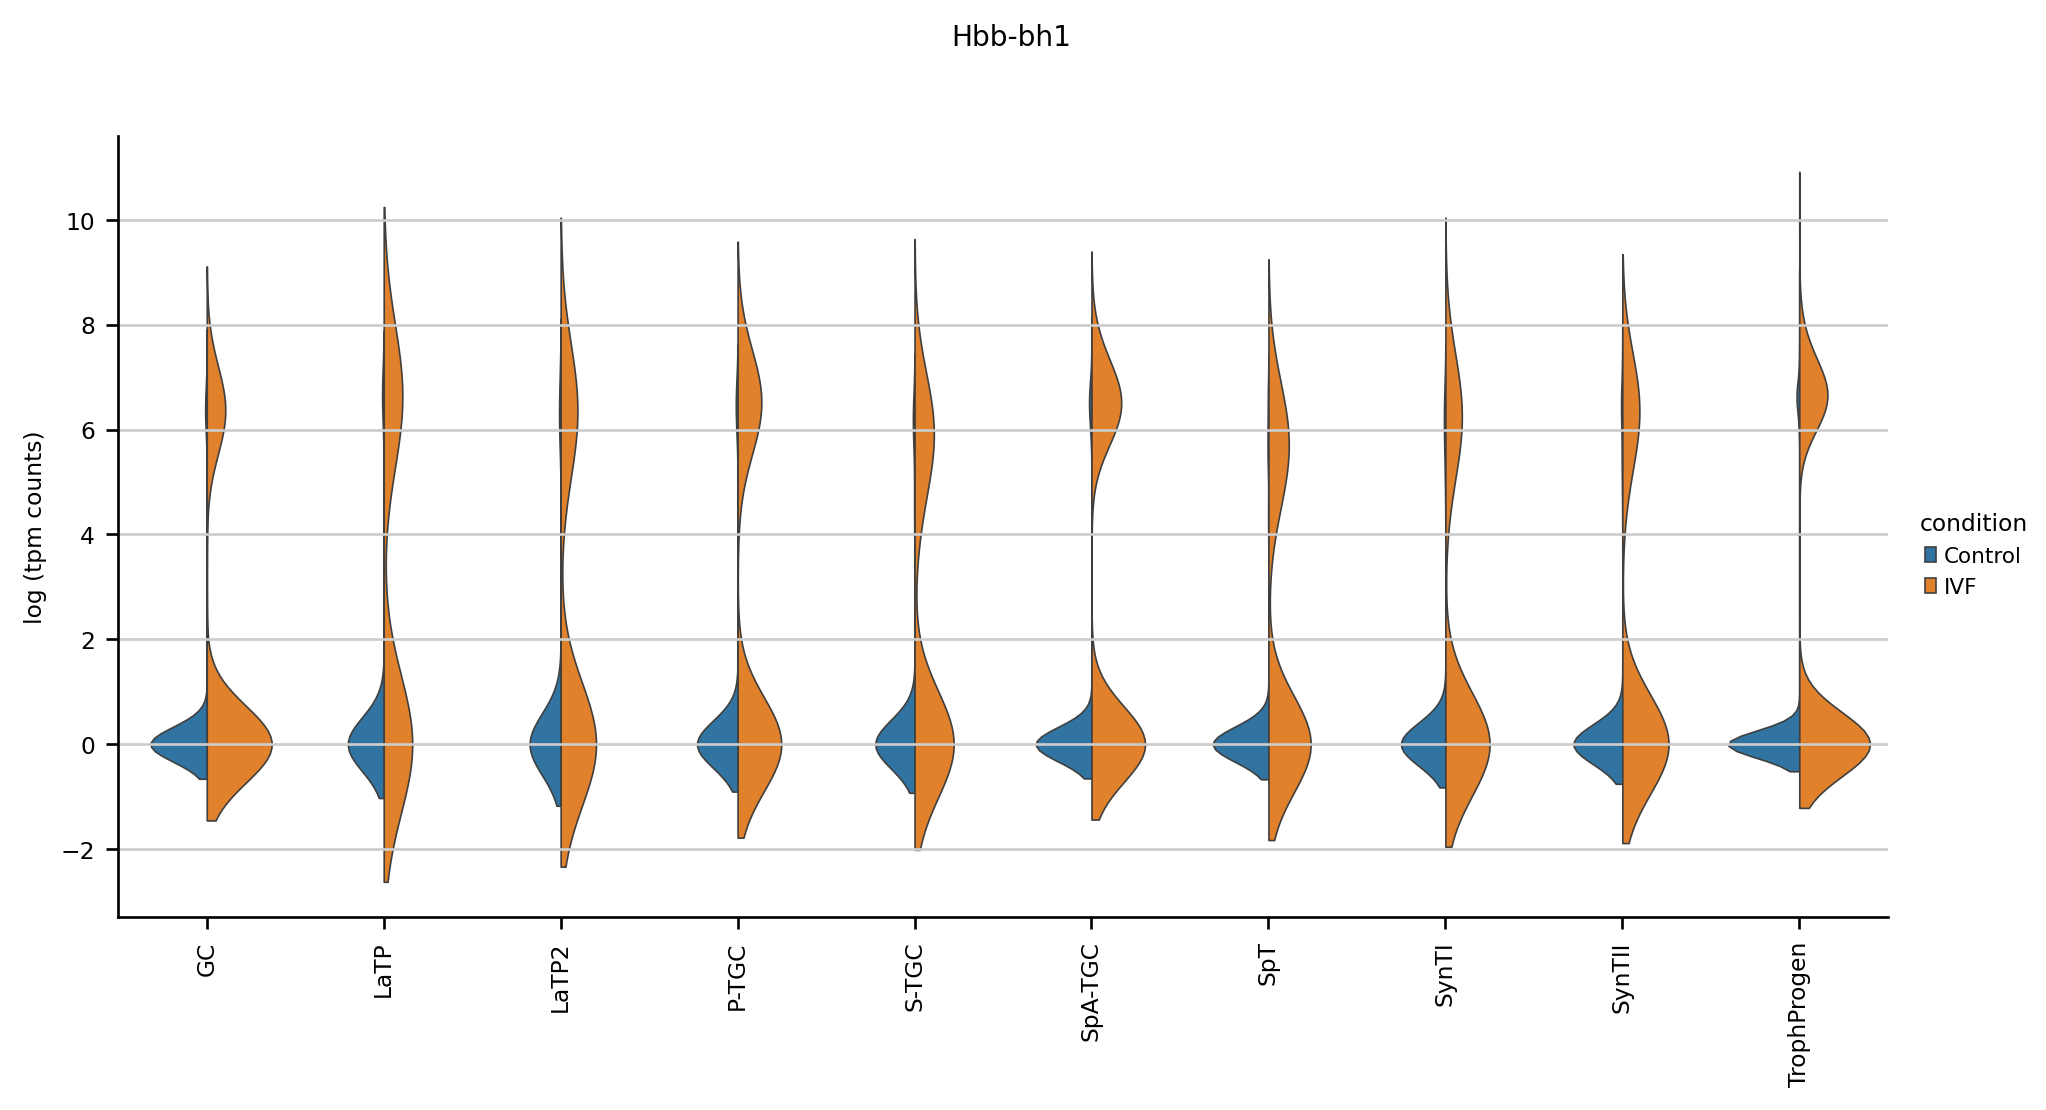

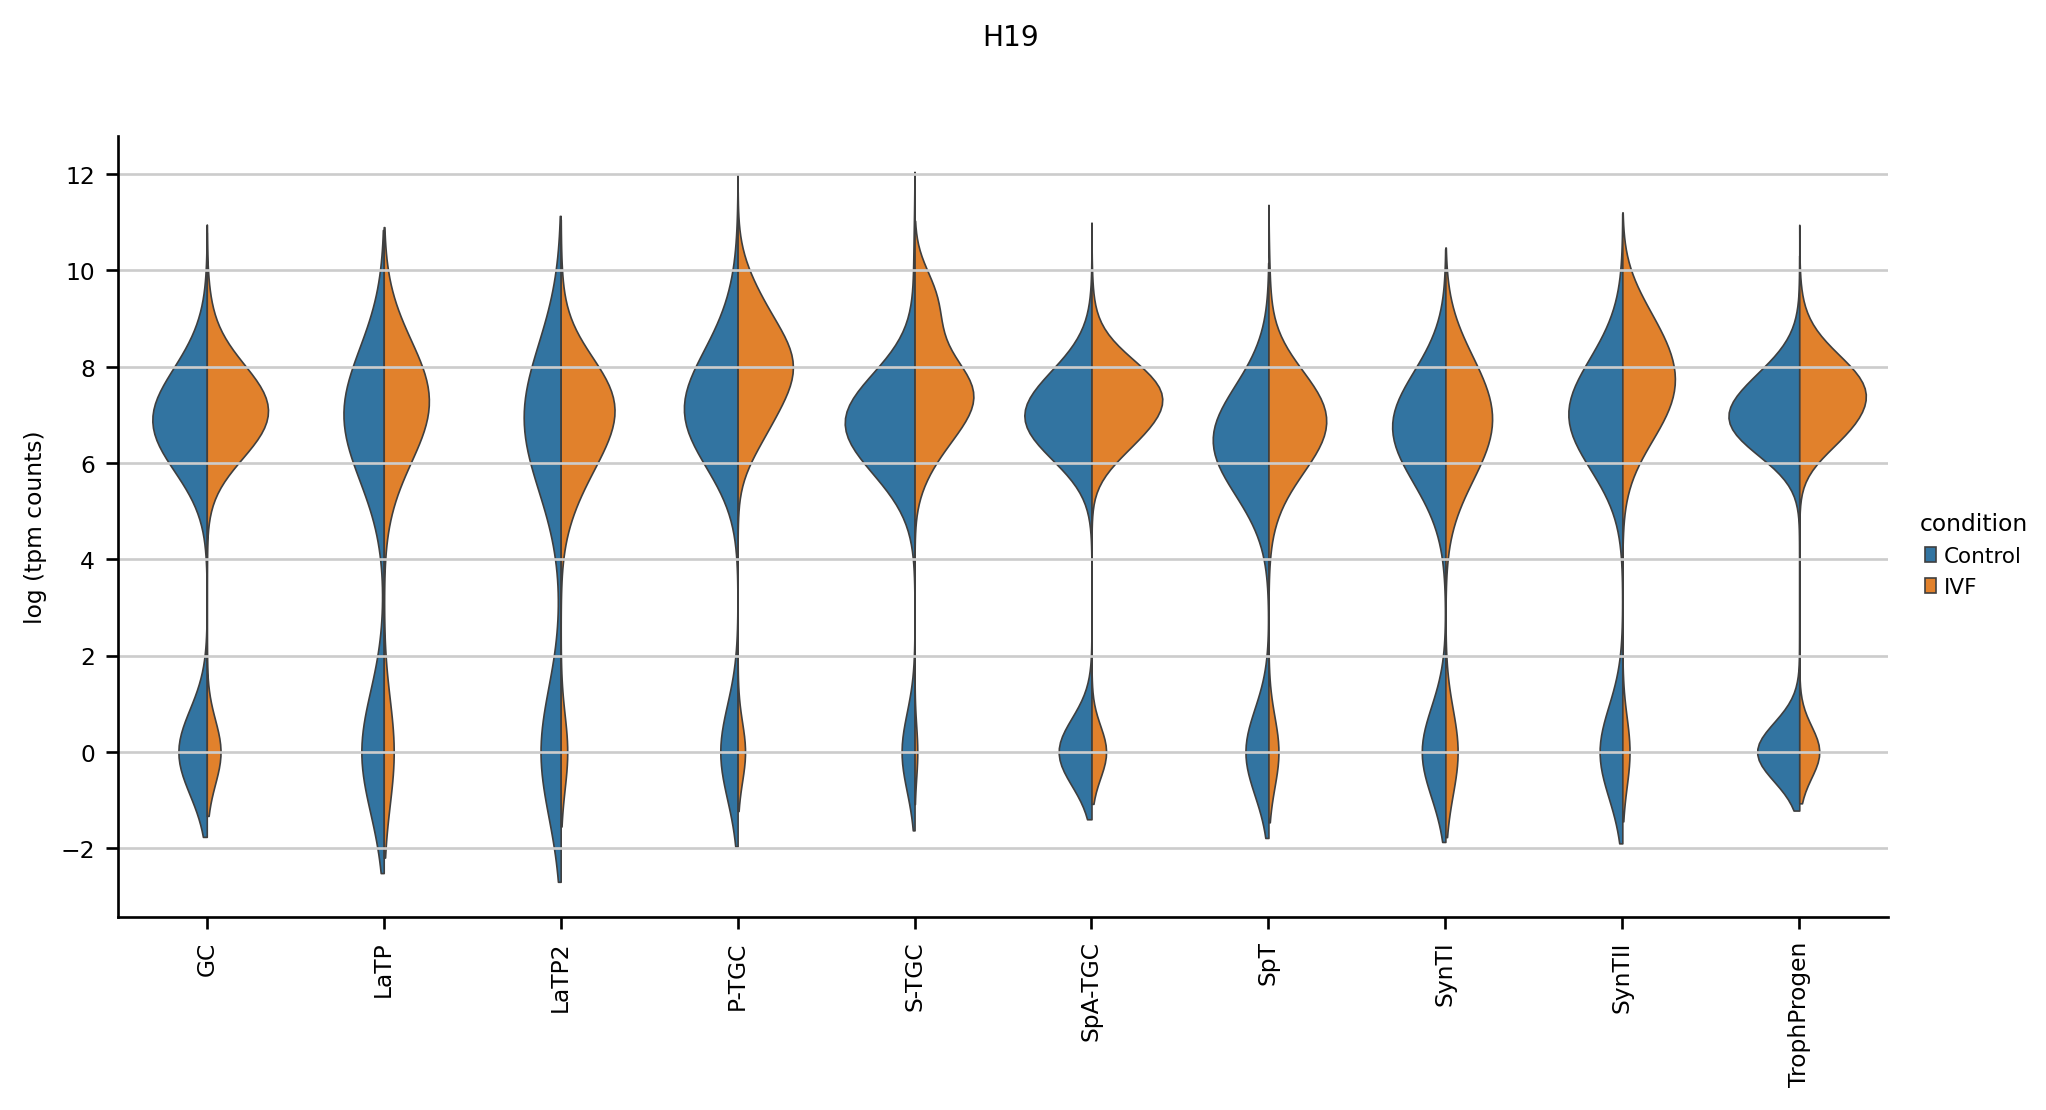

In [ ]:
# Split violin plots for each cluster between conditions
query_gene_list = ['Prl3d1','Prl7a1','Prl2c3','Tfpi','Hbb-bh1', 'H19']

group_by = 'Annot_subtype'
contrast_by = 'condition'

for q in query_gene_list:
  df = sc.get.obs_df(adata_troph, [q] + [group_by, contrast_by], use_raw=False, layer='tpm')
  df2 = df.melt(id_vars=[group_by,'condition'], value_vars=q)
  g = sns.catplot(x = group_by, y = 'value', hue=contrast_by, kind='violin', split=True,
                col='variable', data=df2, col_wrap=1, inner=None, height=4, aspect=2, linewidth=0.5)
  g.set_xticklabels(rotation=90)
  g.set_titles('')  # Example of adding text to the column titles
  g.fig.suptitle(q, y=1.05)  # Adjust `y` to position the title
  g.set_axis_labels('', 'log (tpm counts)')  # Set an empty string for x-axis label if not needed


## Overlay a single DEG on the trophoblast subset embedding

In [ ]:
# Plot condition UMAP overlays for select transcripts - use log tpm counts layer and same colormap range for all
query_gene_list = ['Egln3','Elob','Eloc','Serpine1','Eif4e','Eif4ebp1', 'Eno1','Hmox1','Ldha','Ldhb','Nos2','Pgk1']
condition_list = ['Control', 'IVF']
layer = 'tpm'
vmin = 0
vmax = 12

with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  for query in query_gene_list:
    tpm_counts = sc.get.obs_df(adata_troph, query, layer='tpm')
    #vmax = math.ceil(np.max(tpm_counts)); print(vmax)

    for condition in condition_list:
      ax = sc.pl.umap(adata_troph, color=None, size=20, show=False, vmin=vmin, vmax=vmax, layer=layer)
      ax = sc.pl.umap(adata_troph[adata_troph.obs['condition'] == condition], size=10, color=query, color_map='viridis', title=condition+'-'+query, vmin=vmin, vmax=vmax, ax=ax, layer=layer, sort_order=True)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Plot condition UMAP overlays for select transcripts - use log tpm counts layer and same colormap range for all
query_gene_list = ['Prl3d1','Prl7a1','Prl2c3','Tfpi','Hbb-bh1', 'H19']
condition_list = ['Control', 'IVF']
layer = 'tpm'
vmin = 0
vmax = 12

with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  for query in query_gene_list:
    tpm_counts = sc.get.obs_df(adata_troph, query, layer='tpm')
    #vmax = math.ceil(np.max(tpm_counts)); print(vmax)

    for condition in condition_list:
      ax = sc.pl.umap(adata_troph, color=None, size=20, show=False, vmin=vmin, vmax=vmax, layer=layer)
      ax = sc.pl.umap(adata_troph[adata_troph.obs['condition'] == condition], size=10, color=query, color_map='viridis', title=condition+'-'+query, vmin=vmin, vmax=vmax, ax=ax, layer=layer, sort_order=True)


Output hidden; open in https://colab.research.google.com to view.

## Save trophoblast subset embedding

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Rinaudo-Maltepe-IVF/250121/'

In [ ]:
adata_troph.write(save_path + 'RinaudoMaltepe2023_250121_adatatroph_processed.h5ad', compression='gzip')
adata_troph

AnnData object with n_obs × n_vars = 16946 × 32285
    obs: 'library_id', 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'doublet_score', 'predicted_doublet', 'batch', 'leiden', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'reza', 'dew', 'leiden_dew', 'condition', 'Annot', 'Annot_celltype', 'Annot_subtype', 'Annot_subtype_leiden', 'Annot_cellsubtype_leiden', 'umap_density_condition', 'condition_density'
    var: 'gene_ids', 'feature_types', 'mito', 'ribo', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by

In [ ]:
adata_troph = sc.read(save_path + 'RinaudoMaltepe2023_250121_adatatroph_processed.h5ad')
adata_troph

AnnData object with n_obs × n_vars = 16946 × 32285
    obs: 'library_id', 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'doublet_score', 'predicted_doublet', 'batch', 'leiden', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'reza', 'dew', 'leiden_dew', 'condition', 'Annot', 'Annot_celltype', 'Annot_subtype', 'Annot_subtype_leiden', 'Annot_cellsubtype_leiden', 'umap_density_condition', 'condition_density'
    var: 'gene_ids', 'feature_types', 'mito', 'ribo', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by

In [ ]:
adata_troph.uns['pyDESeq2-dew-231129'].keys()

dict_keys(['Blood-12', 'Blood-8', 'Blood-Eryth-15', 'Blood-Eryth-20', 'DecidualStroma-1', 'DecidualStroma-13', 'DecidualStroma-16', 'DecidualStroma-3', 'DecidualStroma-6', 'Endothelial-22', 'Endothelial-28', 'Endothelial-9', 'FetalMes-10', 'FetalMes-11', 'FetalMes-17', 'FetalMes-23', 'FetalMes-25', 'FetalMes-27', 'FetalMes-31', 'FetalMes-5', 'Trophoblast-0', 'Trophoblast-14', 'Trophoblast-19', 'Trophoblast-2', 'Trophoblast-26', 'Trophoblast-30', 'Trophoblast-32', 'Trophoblast-4', 'Trophoblast-7', 'Trophoblast-STGC-29', 'Trophoblast-SynTI-21', 'Trophoblast-SynTII-18', 'unknown-24', 'unknown-33', 'unknown-34', 'unknown-35', 'unknown-36', 'unknown-37'])

# Sex-Specific Marker Analysis

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Rinaudo-Maltepe-IVF/250121/'
adata_troph = sc.read(save_path + 'RinaudoMaltepe2023_250121_adatatroph_processed.h5ad')
adata_troph

AnnData object with n_obs × n_vars = 16946 × 32285
    obs: 'library_id', 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'doublet_score', 'predicted_doublet', 'batch', 'leiden', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'reza', 'dew', 'leiden_dew', 'condition', 'Annot', 'Annot_celltype', 'Annot_subtype', 'Annot_subtype_leiden', 'Annot_cellsubtype_leiden', 'umap_density_condition', 'condition_density'
    var: 'gene_ids', 'feature_types', 'mito', 'ribo', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by

In [ ]:
# Subset to fetal-derived clusters to minimize maternal cell contributions
fetal_derived_clusters = ['SynTI','SynTII','S-TGC','SpT','GC']
adata_fetal = adata_troph[adata_troph.obs['Annot_subtype'].isin(fetal_derived_clusters)].copy()
len(adata_fetal)

3734

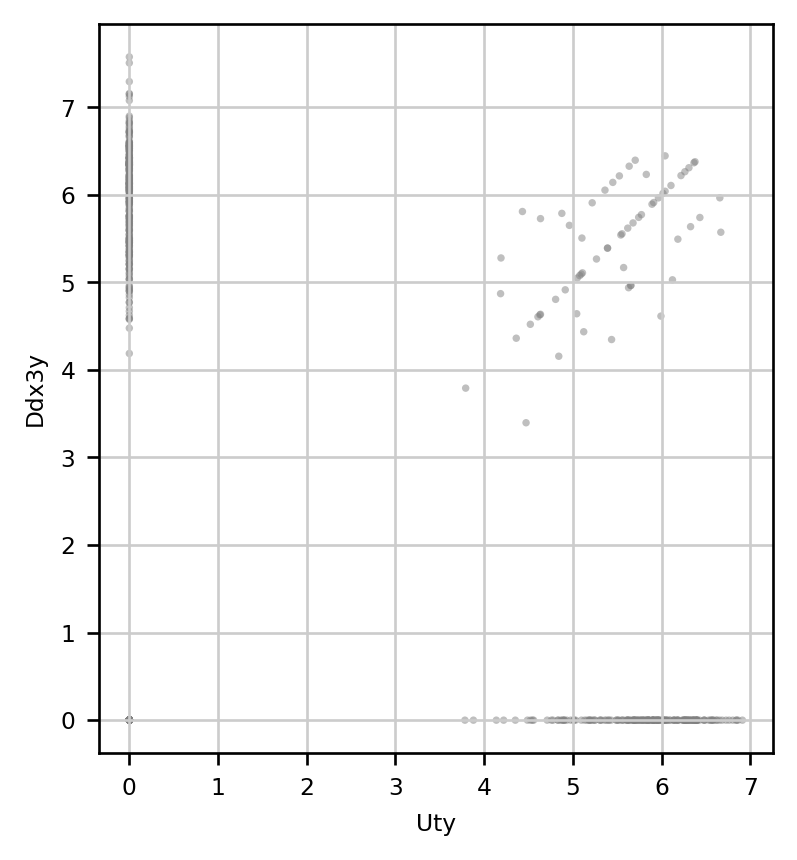

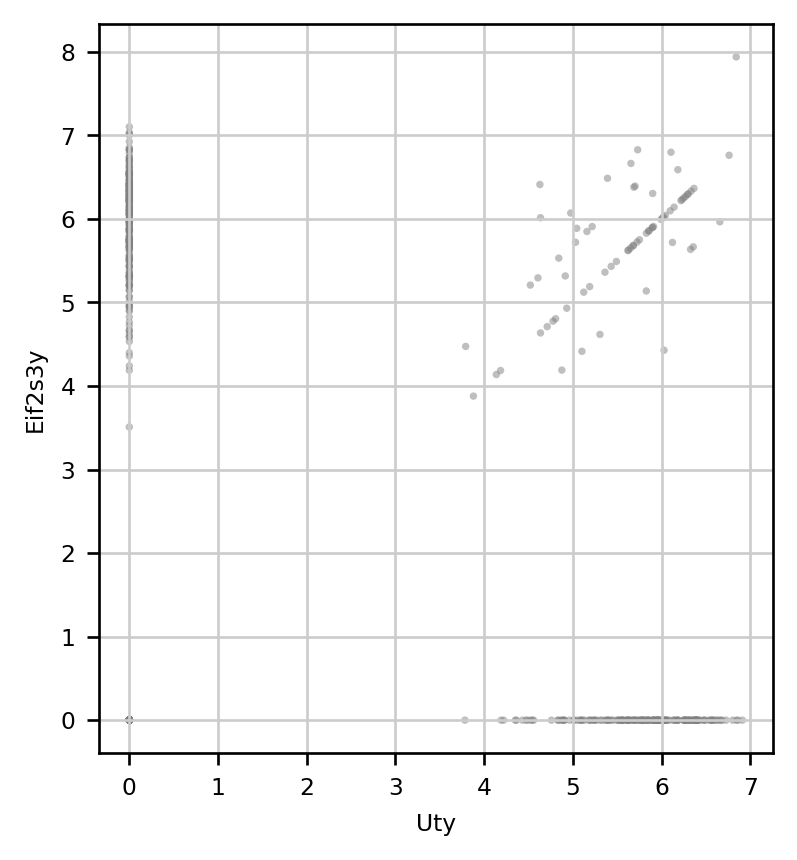

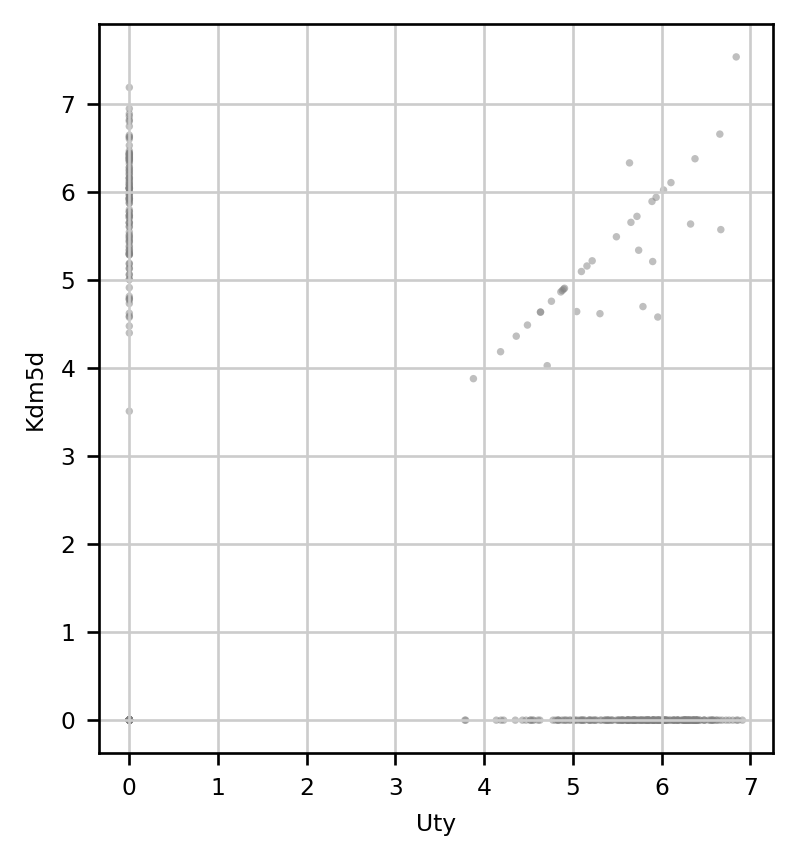

In [ ]:
# Confirm that our XY markers, while a bit noisy in isolation, actually show correlated expression - they do!
sc.pl.scatter(adata_fetal, x='Uty', y='Ddx3y', size=20, alpha=0.5, layers='tpm')
sc.pl.scatter(adata_fetal, x='Uty', y='Eif2s3y', size=20, alpha=0.5, layers='tpm')
sc.pl.scatter(adata_fetal, x='Uty', y='Kdm5d', size=20, alpha=0.5, layers='tpm')

/usr/local/lib/python3.11/dist-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


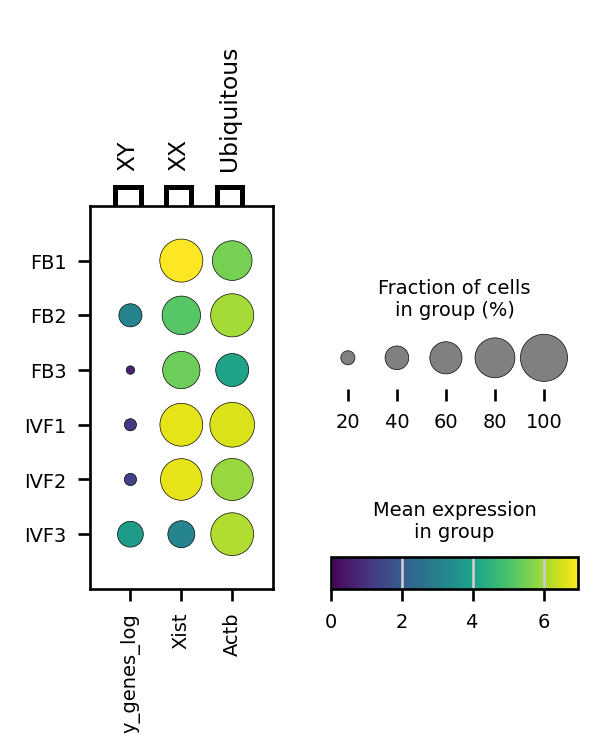

In [ ]:
# Sum counts for curated y marker genes
y_genes = ['Uty','Ddx3y','Eif2s3y','Kdm5d']
adata_fetal.obs['y_genes'] = adata_fetal[:, y_genes].layers['tpm_nolog'].sum(axis=1)
adata_fetal.obs['y_genes_log'] = adata_fetal[:, y_genes].layers['tpm'].sum(axis=1)

marker_dict = {'XY': ['y_genes_log'],
               'XX': ['Xist'],
               'Ubiquitous': ['Actb']}

sc.pl.dotplot(adata_fetal, var_names=marker_dict, layer='tpm', groupby='library_id', cmap='viridis',
              save='xx_xy_sums_logtpm.pdf')

In [ ]:
import pandas as pd
import numpy as np

def get_sex_genotypes(
    adata,
    XY_specific_transcripts,
    XX_specific_transcripts=None,
    layer=None,
    normalize_by='XX',  # 'XX', 'total', or None
    pseudocount=1e-3,
    log2fc_threshold=10,
    prefix='',
    method='xy_vs_xx',  # 'xy_vs_xx' or 'xist_only'
    xist_gene='Xist'    # used if method='xist_only'
):
    """
    Compute sex assignments based on XY/XX expression ratios or Xist expression alone.

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    XY_specific_transcripts : list of str
        List of Y-linked or XY-specific transcripts.
    XX_specific_transcripts : list of str or None
        Reference transcripts for normalization.
    layer : str or None
        Use this layer instead of .X.
    normalize_by : {'XX', 'total', None}
        Normalization strategy.
    pseudocount : float
        Value added to numerator and denominator to avoid log(0).
    log2fc_threshold : float
        Threshold to call sex from log2 ratio (xy_vs_xx mode).
    prefix : str
        Prefix for adata.obs output columns.
    method : {'xy_vs_xx', 'xist_only'}
        Strategy to assign sex.
    xist_gene : str
        Gene name to use when method='xist_only'.

    Returns
    -------
    None
        Modifies adata.obs in place.
    """
    X = adata.X if layer is None else adata.layers[layer]
    if hasattr(X, "toarray"):  # sparse matrix support
        X = X.toarray()

    var_names = adata.var_names

    if method == 'xy_vs_xx':
        XY_idx = [i for i, g in enumerate(var_names) if g in XY_specific_transcripts]
        XX_idx = [i for i, g in enumerate(var_names) if XX_specific_transcripts and g in XX_specific_transcripts]

        XY_sum = X[:, XY_idx].sum(axis=1)
        if normalize_by == 'XX':
            if not XX_specific_transcripts:
                raise ValueError("XX_specific_transcripts must be provided if normalize_by='XX'")
            XX_sum = X[:, XX_idx].sum(axis=1)
            log2_ratio = np.log2((XY_sum + pseudocount) / (XX_sum + pseudocount))
        elif normalize_by == 'total':
            total_sum = X.sum(axis=1)
            log2_ratio = np.log2((XY_sum + pseudocount) / (total_sum + pseudocount))
            XX_sum = total_sum - XY_sum
        else:
            log2_ratio = None
            XX_sum = X[:, XX_idx].sum(axis=1) if XX_specific_transcripts else np.zeros(X.shape[0])

        # Assign to .obs
        adata.obs[f'{prefix}XY_sum'] = XY_sum
        adata.obs[f'{prefix}XX_sum'] = XX_sum
        if log2_ratio is not None:
            adata.obs[f'{prefix}log2_mf_ratio'] = log2_ratio
            sex = np.select(
                [log2_ratio > log2fc_threshold, log2_ratio < -log2fc_threshold],
                ['XY', 'XX'],
                default='Unknown'
            )
            adata.obs[f'{prefix}sex'] = sex

            # Show counts for user
            counts = pd.Series(sex, index=adata.obs_names).value_counts()
            print("Sex counts:")
            print(counts)

    elif method == 'xist_only':
        if xist_gene not in var_names:
            raise ValueError(f"{xist_gene} not found in adata.var_names")

        xist_idx = var_names.get_loc(xist_gene)
        xist_expr = X[:, xist_idx]
        if hasattr(xist_expr, "toarray"):
            xist_expr = xist_expr.toarray().flatten()

        adata.obs[f'{prefix}Xist_expr'] = xist_expr
        sex = np.where(xist_expr > 0, 'XX', 'XY')
        adata.obs[f'{prefix}sex'] = sex

        # Show counts
        counts = pd.Series(sex, index=adata.obs_names).value_counts()
        print("Sex counts (Xist only):")
        print(counts)

    else:
        raise ValueError(f"Unknown method: {method}")


In [ ]:
# Assign XY flags to each cell
get_sex_genotypes(
    adata_fetal,
    XY_specific_transcripts=y_genes,
    XX_specific_transcripts='Xist',
    normalize_by='XX',
    method='xy_vs_xx',
    layer='tpm_nolog')

Sex counts:
XX         2420
Unknown    1093
XY          221
Name: count, dtype: int64


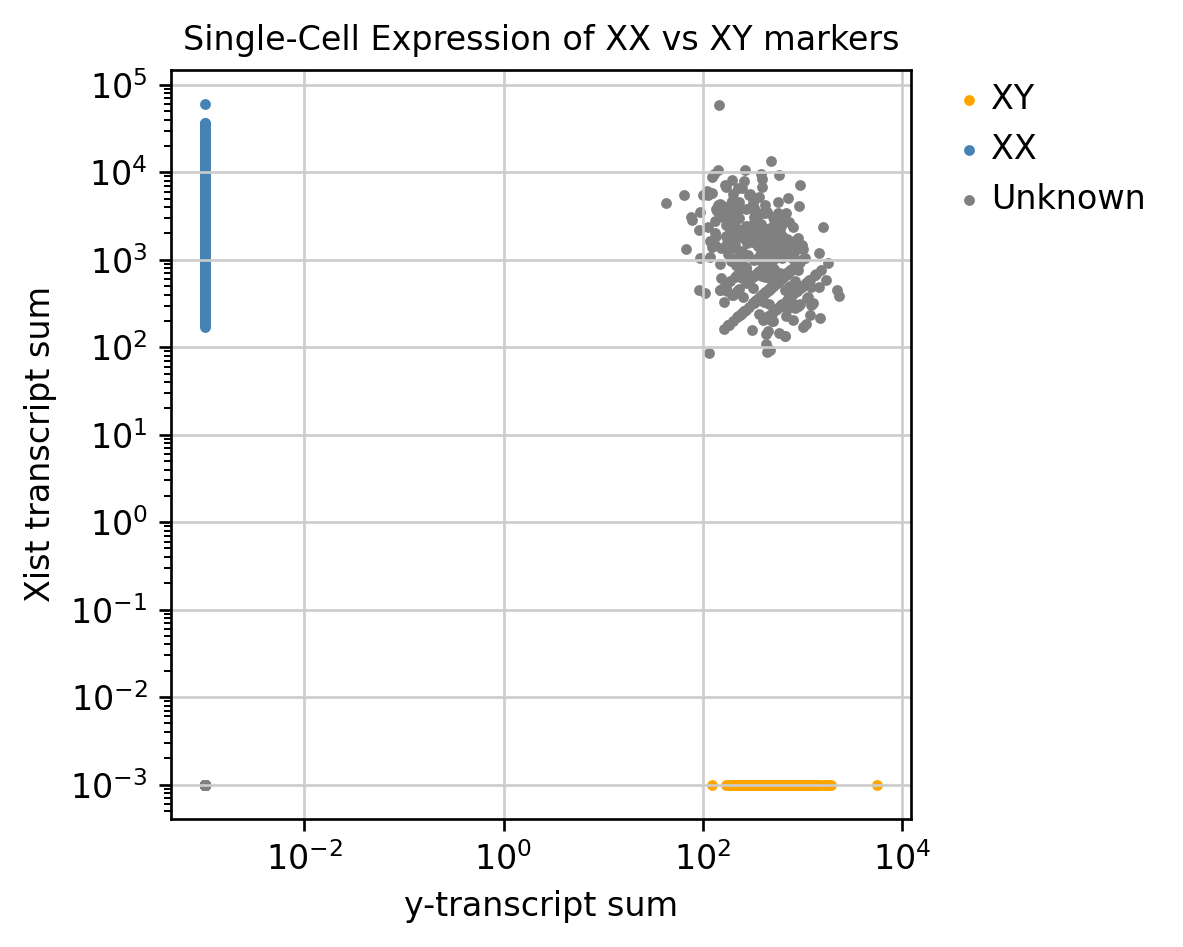

In [ ]:
# Scatterplot of XX and XY markers for each cell - overlay genotype assignments

import matplotlib.pyplot as plt

df = adata_fetal.obs[['XY_sum', 'XX_sum', 'sex']].copy()

fig, ax = plt.subplots(figsize=(5, 4))
for sex_label, color in zip(['XY', 'XX', 'Unknown'], ['orange', 'steelblue', 'gray']):
    subset = df[df['sex'] == sex_label]
    ax.scatter(subset['XY_sum']+1e-3, subset['XX_sum']+1e-3,
               label=sex_label, alpha=1, s=5, c=color)

ax.set_title("Single-Cell Expression of XX vs XY markers", fontsize=10)
ax.set_xlabel("y-transcript sum", fontsize=10)
ax.set_ylabel("Xist transcript sum", fontsize=10)
ax.legend(
    bbox_to_anchor=(1.05, 1),  # X, Y anchor point (1.05 moves it outside)
    loc='upper left',          # Anchor relative to legend box
    borderaxespad=0,
    frameon=False,
    fontsize=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.savefig('figures/sc_gtyping_scatter.pdf')
plt.show()


In [ ]:
summary = (adata_fetal.obs
    #.groupby(['library_id','Annot_subtype'])['sex']
    .groupby(['library_id'])['sex']
    .value_counts()
    .unstack(fill_value=0)
    .sort_index())

summary['XY_ratio'] = round(summary['XY'] / (summary['XY']+summary['XX']+summary['Unknown']) * 100,1)
summary['XX_ratio'] = round(summary['XX'] / (summary['XY']+summary['XX']+summary['Unknown']) * 100,1)
summary['Unknown_ratio'] = round(summary['Unknown'] / (summary['XY']+summary['XX']+summary['Unknown']) * 100,1)
summary


sex         Unknown   XX   XY  XY_ratio  XX_ratio  Unknown_ratio
library_id                                                      
FB1              95  732    0       0.0      88.5           11.5
FB2             290  316   64       9.6      47.2           43.3
FB3             146  300   11       2.4      65.6           31.9
IVF1            219  666   19       2.1      73.7           24.2
IVF2             91  283   17       4.3      72.4           23.3
IVF3            252  123  110      22.7      25.4           52.0

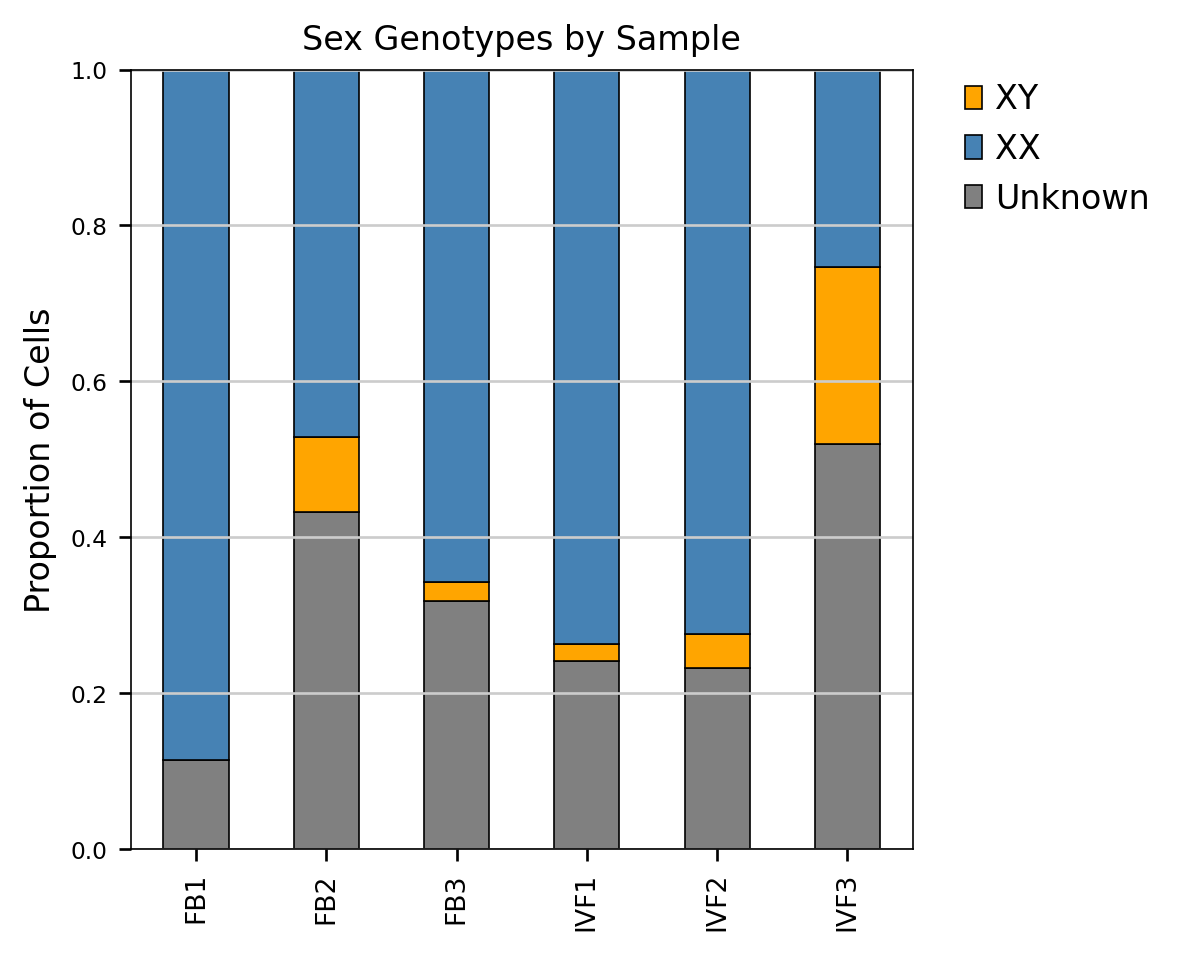

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is called `df` and has a MultiIndex (library_id, Annot_subtype)
# Reset index for easier plotting
df_plot = summary.reset_index().drop(columns=['XY','XX','Unknown'])

# Create a single column identifier for bar groups
df_plot['group'] = df_plot['library_id'].astype(str)

# Set index to 'group' for plotting
df_plot = df_plot.set_index('group').rename(columns={'Unknown_ratio': 'Unknown', 'XX_ratio': 'XX', 'XY_ratio': 'XY'})


# Plot
ax = df_plot[['Unknown','XY', 'XX']].div(100).plot(
    kind='bar',
    stacked=True,
    figsize=(5, 4),
    color=['grey','orange', 'steelblue'],
    edgecolor='black',
    linewidth=0.5
)

# Labels
ax.set_ylabel("Proportion of Cells", fontsize=10)
ax.set_xlabel("", fontsize=10)
ax.set_title("Sex Genotypes by Sample", fontsize=10)
ax.legend()
handles, labels = ax.get_legend_handles_labels()
legend_order = ['XY', 'XX', 'Unknown']  # Custom order
reordered = sorted(zip(labels, handles), key=lambda x: legend_order.index(x[0]))
new_labels, new_handles = zip(*reordered)

# Set the legend with new order
ax.legend(new_handles, new_labels, loc='upper left',bbox_to_anchor=(1.05, 1),  # X, Y anchor point (1.05 moves it outside)
    borderaxespad=0,
    frameon=False,
    fontsize=10)

ax.set_ylim(0, 1)  # if you're plotting proportions from 0 to 1

for spine in ax.spines.values():
    spine.set_linewidth(0.5)  # thinner frame


plt.xticks(rotation=90, fontsize=8)
ax.grid(axis='x', visible=False)
#ax.grid(axis='y', visible=False)
plt.tight_layout()
plt.savefig('figures/sc_gtyping_stackedbar.pdf')
plt.show()


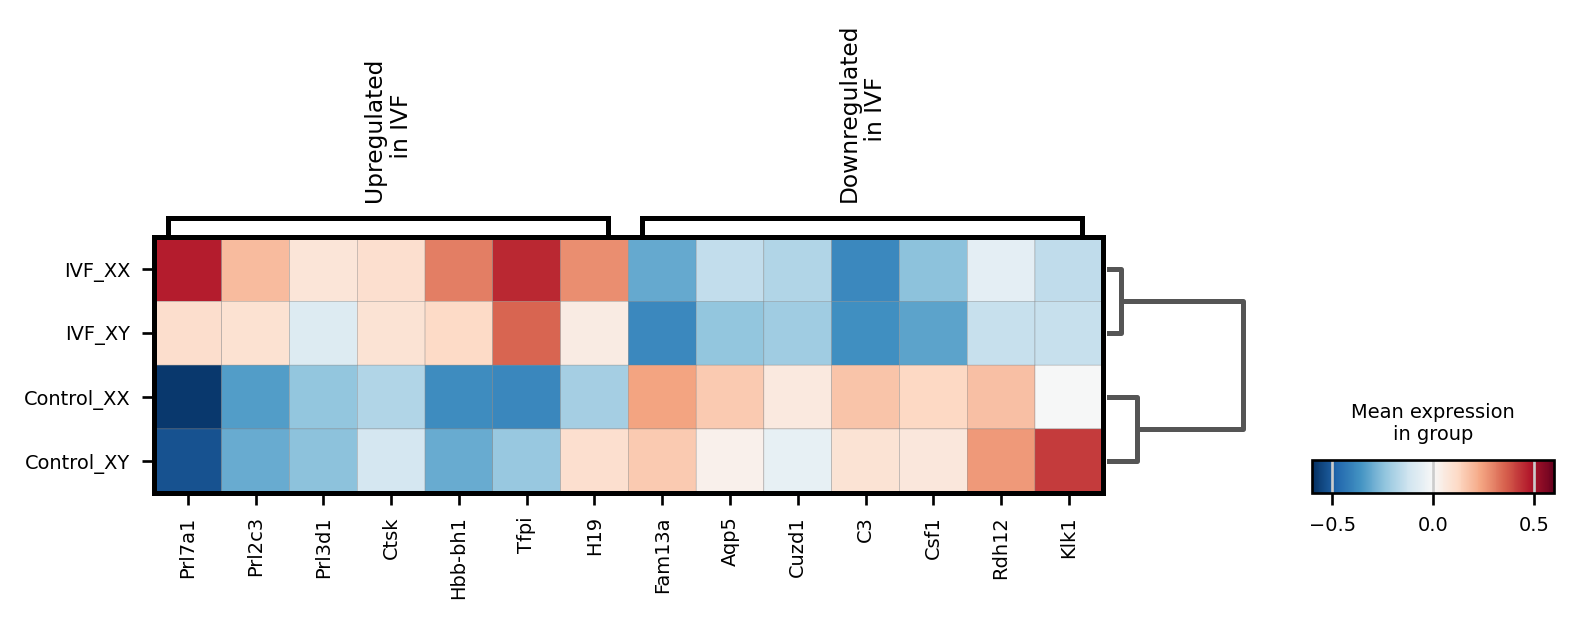

In [ ]:
# For DEG genes identified in the main analysis, generate a matrixplot to summarize expression trends by condition and sex

adata_use = adata_fetal[adata_fetal.obs['sex'].isin(['XX','XY'])].copy()
adata_use.obs['sex'] = adata_use.obs['sex'].astype('category')
sc.tl.dendrogram(adata_use, groupby=['condition','sex'])

sc.pl.matrixplot(adata_use, var_names={'Upregulated\n in IVF':['Prl7a1','Prl2c3','Prl3d1','Ctsk','Hbb-bh1','Tfpi','H19'],
                                       'Downregulated\n in IVF':['Fam13a','Aqp5','Cuzd1','C3','Csf1','Rdh12','Klk1']},
                 groupby=['condition','sex'],
                 vmin=-0.6, vmax=0.6,
                 cmap='RdBu_r',
                 dendrogram=True,
                 save = 'IVF_DE_by_sex.pdf')


In [ ]:
!jupyter nbconvert --to html /content/drive/MyDrive/Colab\ Notebooks/Rinaudo-Maltepe-IVF/Oqani2025_analysis.ipynb